In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import timm  
import os
import random  
from tqdm.notebook import tqdm 
from torchvision import transforms as T, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.utils import make_grid
from torch import nn 
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns 
import csv

In [6]:
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomRotation(degrees=20),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
full_dataset = datasets.ImageFolder(root='./Data')

In [29]:
from collections import Counter

class_counts = Counter(full_dataset.targets)
num_classes = len(full_dataset.classes)
total_samples = len(full_dataset)

weights = {class_idx: total_samples / (num_classes * count) for class_idx, count in class_counts.items()}

In [30]:
print(weights)

{0: 1.1510158013544018, 1: 0.8746140651801029, 2: 1.0556935817805384, 3: 1.6161648177496037, 4: 0.7033103448275863}


In [10]:
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
def augment_dataset(dataset, augmentation_transforms, augmentation_factor=0):
    augmented_data = []
    num_new_images = int(len(dataset) * augmentation_factor)
    for _ in range(num_new_images):
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset.dataset[index]  # Access the underlying dataset
        augmented_image = augmentation_transforms(image)
        augmented_data.append((augmented_image, label))
    return augmented_data

In [13]:
original_train_dataset = CustomDataset(train_dataset, transform=train_transforms)
augmented_data = augment_dataset(original_train_dataset.dataset, train_transforms, augmentation_factor=0.05)
combined_train_dataset = ConcatDataset([original_train_dataset, augmented_data])

val_data = CustomDataset(val_dataset, transform=val_transforms)

In [14]:
del original_train_dataset, augmented_data

In [17]:
batch_size = 20

train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [18]:
# Function to show an image grid with an optional title.
def show_grid(image, title=None):
    image = image.permute(1, 2, 0)  # Rearranging the image tensor dimensions
    mean = torch.FloatTensor([0.485, 0.456, 0.406])  # Mean for denormalization
    std = torch.FloatTensor([0.229, 0.224, 0.225])  # Standard deviation for denormalization

    image = image * std + mean  # Apply denormalization
    image = np.clip(image, 0, 1)  # Clip values to be between 0 and 1

    plt.figure(figsize=[15, 15])  # Set the size of the figure
    plt.imshow(image)  # Display the image grid
    if title is not None:
        plt.title(title)  # Set the title if provided

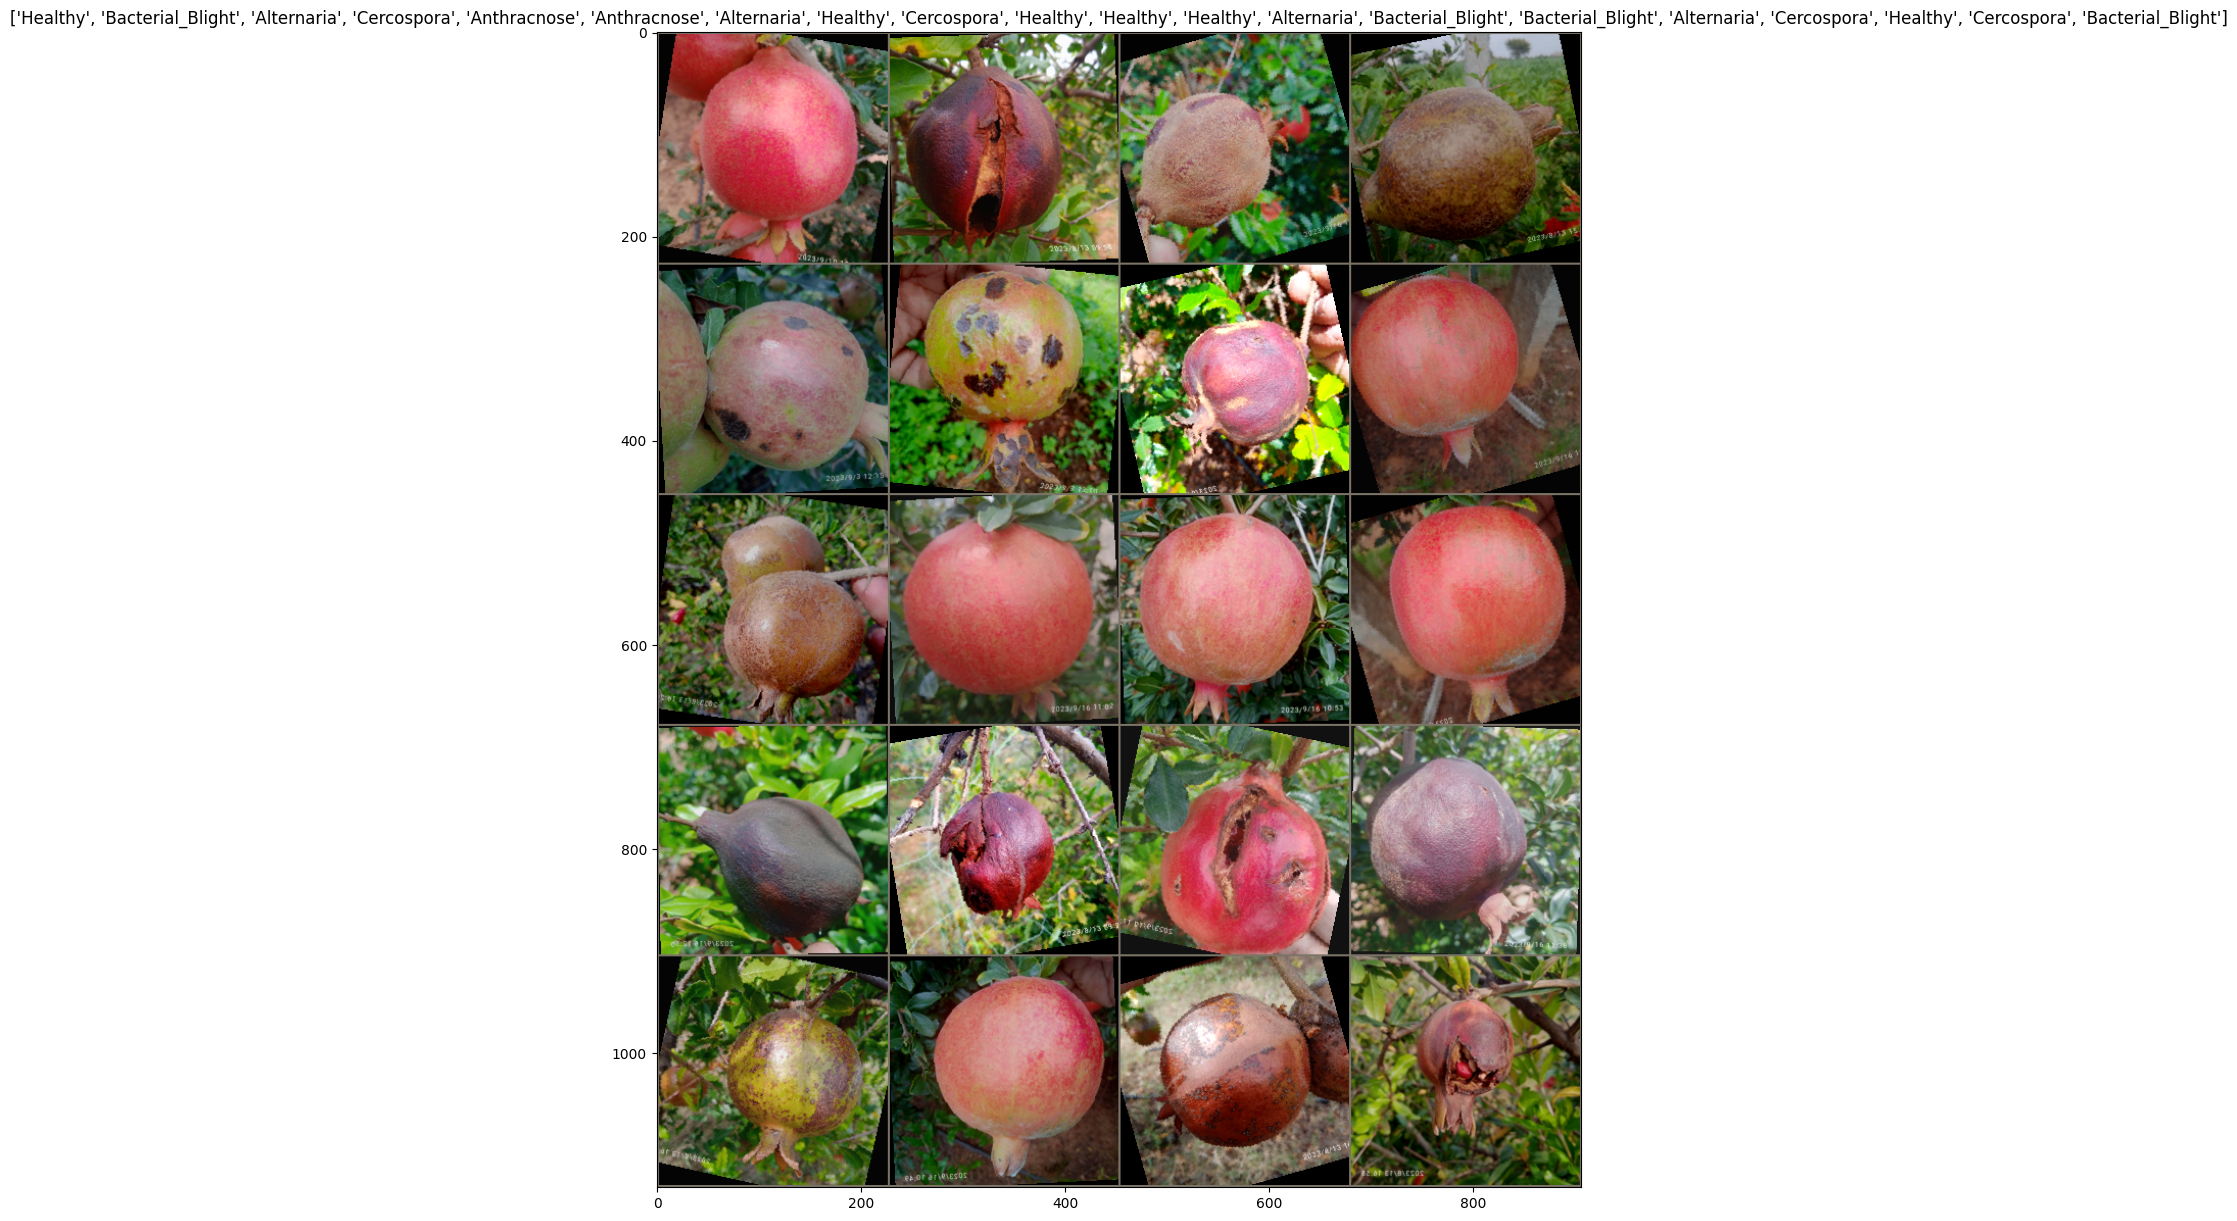

In [19]:
# Defining the class names for the dataset
class_names = ['Alternaria','Anthracnose', 'Bacterial_Blight', 'Cercospora', 'Healthy']  # List of class names, corresponding to the labels in the dataset

# Iterating through the trainloader to fetch a batch of images
dataiter = iter(train_loader)  # Create an iterator for the trainloader
images, labels = dataiter.__next__()  # Fetch the next batch of images and their corresponding labels

# Creating a grid layout of the fetched images
out = make_grid(images, nrow=4)  # Using make_grid to arrange images in a grid format, 4 images per row

# Displaying the grid of images
show_grid(out, title=[class_names[x] for x in labels])  # Using the custom show_grid function to display the images with their class names as titles

In [15]:
model_name = 'davit_base'
model = timm.create_model(model_name, pretrained=True)

In [16]:
# Setting the device for training/testing. Uses GPU if available, else CPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Print statement to confirm the device being used
print("On which device we are on : {}".format(device))

On which device we are on : cuda:1


In [17]:
#num_classes = 5  # 'Alternaria', 'Anthracnose', 'Bacterial Blight', 'Cercospora', 'Healthy'
model.head.fc = nn.Linear(model.head.in_features, num_classes)
model.to(device)  # Transferring the model to the device (GPU or CPU) for efficient computation

DaVit(
  (stem): Stem(
    (conv): Conv2d(3, 128, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
    (norm): LayerNorm2d((128,), eps=1e-05, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): DaVitStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): Sequential(
          (0): SpatialBlock(
            (cpe1): ConvPosEnc(
              (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
              (act): Identity()
            )
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (cpe2): ConvPosEnc(
              (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
  

In [18]:
# Function to calculate the accuracy of predictions.
def accuracy(y_pred, y_true):
    y_pred = F.softmax(y_pred, dim=1)  # Apply softmax to get probability distributions
    top_p, top_class = y_pred.topk(1, dim=1)  # Get the top class predictions
    equals = top_class == y_true.view(*top_class.shape)  # Compare with true labels
    return torch.mean(equals.type(torch.FloatTensor))  # Calculate the mean accuracy

In [19]:
# Trainer class for handling the training and validation of a neural network model for pneumonia detection
class Trainer():

    # Constructor for initializing the trainer with a loss function, optimizer, and scheduler
    def __init__(self, criterion=None, optimizer=None, schedular=None):
        self.criterion = criterion  # Loss function to use
        self.optimizer = optimizer  # Optimizer for adjusting model weights
        self.schedular = schedular  # Learning rate scheduler 
        # Initialize lists to store metrics for plotting
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
    
    # Function to perform the training loop over all batches in the training data
    def train_batch_loop(self, model, trainloader, device):
        train_loss = 0.0  # Variable to accumulate loss over all batches
        train_acc = 0.0   # Variable to accumulate accuracy over all batches

        # Iterate over batches of images and labels in the training dataset
        for images, labels in tqdm(trainloader):
            
            # Move images and labels to the device (GPU or CPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted outputs by passing images to the model
            logits = model(images)
            loss = self.criterion(logits, labels)  # Calculate the batch's loss

            # Backward pass and optimization
            self.optimizer.zero_grad()  # Clear the gradients of all optimized variables
            loss.backward()  # Perform backward pass to calculate gradients
            self.optimizer.step()  # Perform a single optimization step (parameter update)

            # Accumulate loss and accuracy for this batch
            train_loss += loss.item()
            train_acc += accuracy(logits, labels)

        # Calculate average loss and accuracy over all batches
        return train_loss / len(trainloader), train_acc / len(trainloader)
    
    # Function to perform the validation loop over all batches in the validation data
    def valid_batch_loop(self, model, validloader, device):
        valid_loss = 0.0
        valid_acc = 0.0
        all_preds = []
        all_labels = []
        all_logits = []

        for images, labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = self.criterion(logits, labels)

            valid_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
            all_logits.extend(logits.detach().cpu().numpy())

        # Calculate average loss and accuracy
        avg_loss = valid_loss / len(validloader)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)

        # Calculate metrics
        all_preds = np.argmax(all_logits, axis=1)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)

        return avg_loss, accuracy, precision, recall, f1, conf_matrix
    
    def save_metrics_to_csv(self, filepath, epoch):
        with open(filepath, mode='a', newline='') as file:
            writer = csv.writer(file)
            if epoch == 1:  # Write the header only once, at the beginning
                writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy'])
            writer.writerow([epoch, self.train_losses[-1], self.train_accuracies[-1], self.val_losses[-1], self.val_accuracies[-1]])

    def plot_metrics(self, epoch):
        # Plotting training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title(f'Loss after Epoch {epoch}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Training Accuracy')
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.title(f'Accuracy after Epoch {epoch}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

    def fit(self, model, trainloader, validloader, epochs, device):
        metrics_filepath = f'DaViT_Base_training_metrics.csv'
        valid_min_loss = np.Inf

        for i in range(epochs):
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader, device)

            model.eval()
            avg_valid_loss, avg_valid_acc, precision, recall, f1, conf_matrix = self.valid_batch_loop(model, validloader, device)

            if self.schedular:
                self.schedular.step(avg_valid_loss)
            
            # Save the model after every epoch
            epoch_number = i + 1
            model_filename = f'DaViT_Base_Epoch_{epoch_number}.pth'
            torch.save(model.state_dict(), model_filename)
            print(f"Model saved as {model_filename}")

            # Track the best model based on validation loss
            if avg_valid_loss <= valid_min_loss:
                print("Valid_loss decreased {} --> {}".format(valid_min_loss, avg_valid_loss))
                valid_min_loss = avg_valid_loss

            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(epoch_number, avg_train_loss, avg_train_acc))
            print(f"Epoch {epoch_number}/{epochs} - Valid Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

            # Update lists for plotting
            self.train_losses.append(avg_train_loss)
            self.train_accuracies.append(avg_train_acc)
            self.val_losses.append(avg_valid_loss)
            self.val_accuracies.append(avg_valid_acc)

            # Save metrics to CSV after each epoch
            self.save_metrics_to_csv(metrics_filepath, i + 1)

            # Plot metrics
            self.plot_metrics(epoch_number)

            # Plot the confusion matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
                        xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix at Epoch {i + 1}')
            plt.show()

In [20]:
print(torch.cuda.memory_allocated()/1024**2)
print(torch.cuda.memory_reserved()/1024**2)

0.0
0.0


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_1.pth
Valid_loss decreased inf --> 0.16046015248186402
Epoch : 1 Train Loss : 0.353170 Train Acc : 0.878191
Epoch 1/40 - Valid Loss: 0.1605, Accuracy: 0.9510, Precision: 0.9551, Recall: 0.9510, F1 Score: 0.9511


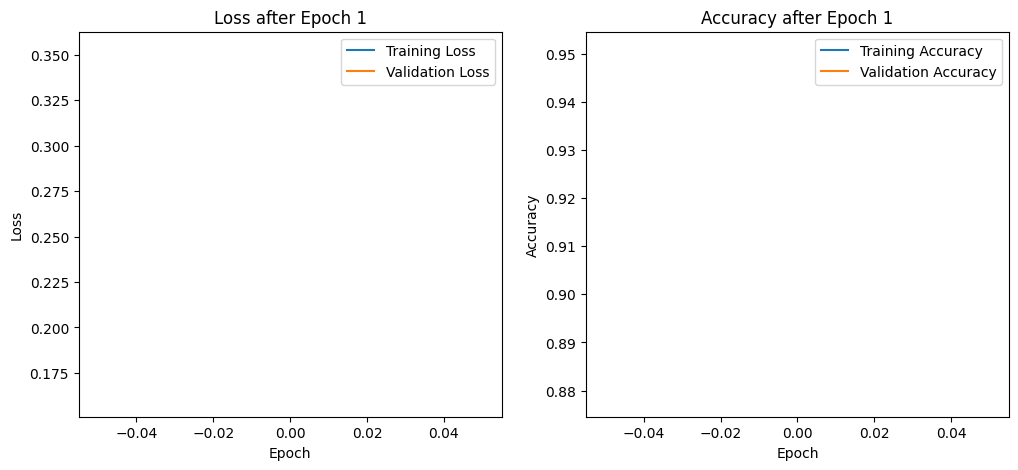

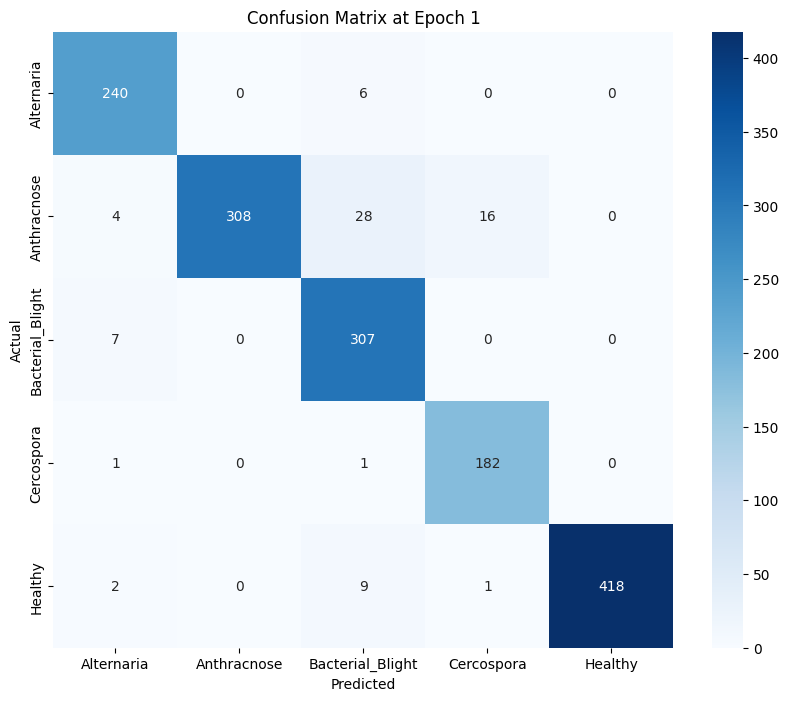

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_2.pth
Valid_loss decreased 0.16046015248186402 --> 0.06588722644192348
Epoch : 2 Train Loss : 0.107784 Train Acc : 0.969718
Epoch 2/40 - Valid Loss: 0.0659, Accuracy: 0.9843, Precision: 0.9846, Recall: 0.9843, F1 Score: 0.9843


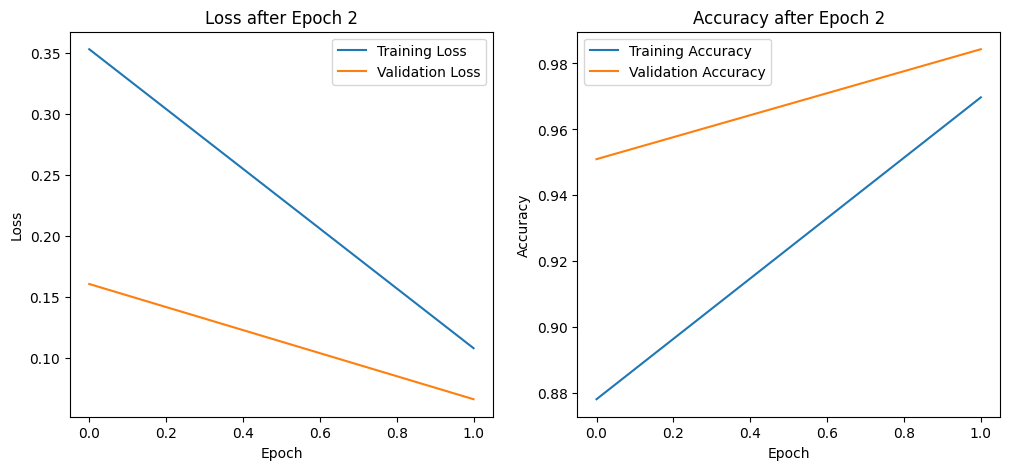

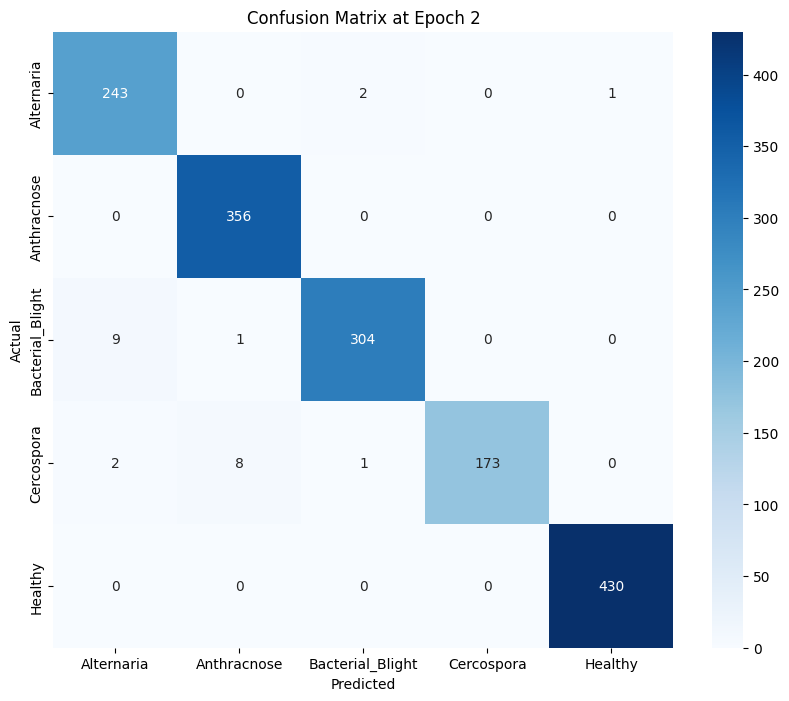

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_3.pth
Valid_loss decreased 0.06588722644192348 --> 0.05451354210252886
Epoch : 3 Train Loss : 0.090307 Train Acc : 0.974468
Epoch 3/40 - Valid Loss: 0.0545, Accuracy: 0.9824, Precision: 0.9826, Recall: 0.9824, F1 Score: 0.9824


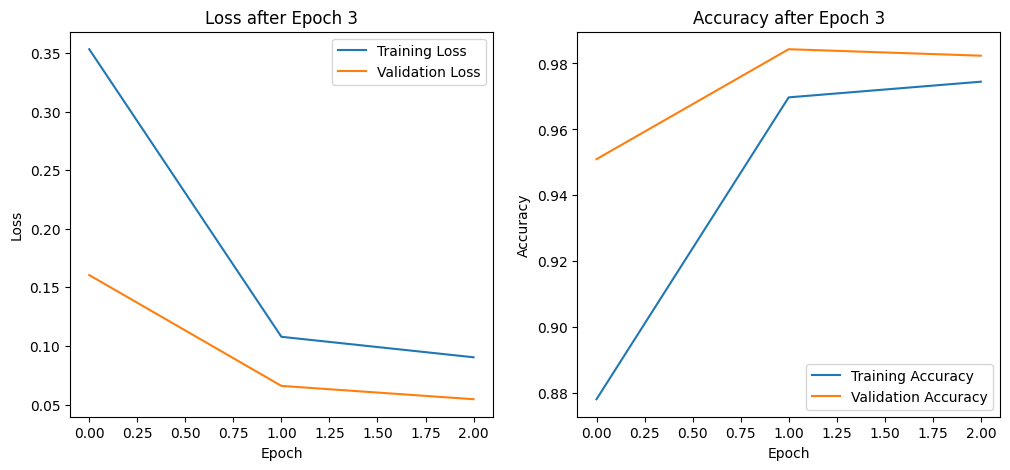

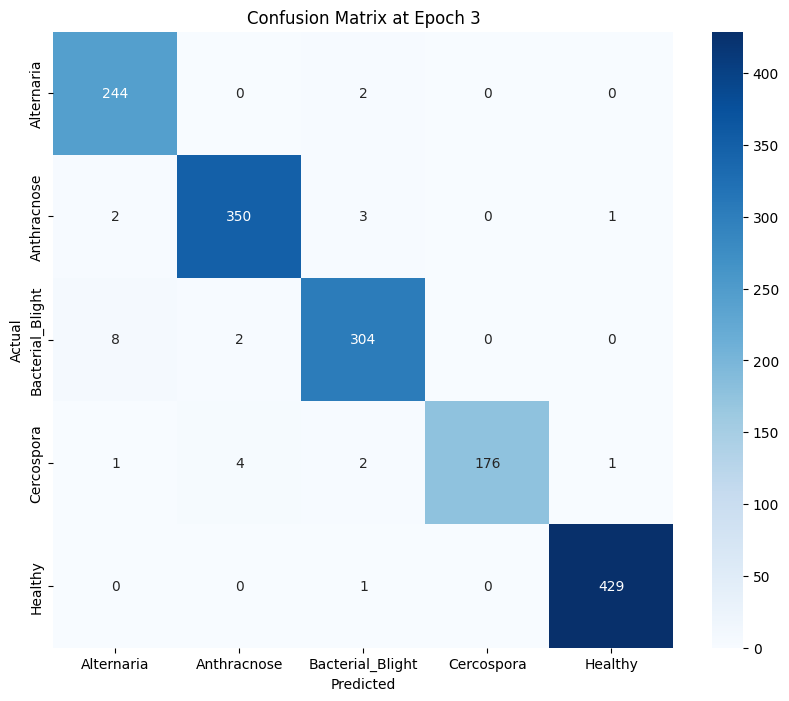

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_4.pth
Epoch : 4 Train Loss : 0.108046 Train Acc : 0.967819
Epoch 4/40 - Valid Loss: 0.0827, Accuracy: 0.9797, Precision: 0.9803, Recall: 0.9797, F1 Score: 0.9797


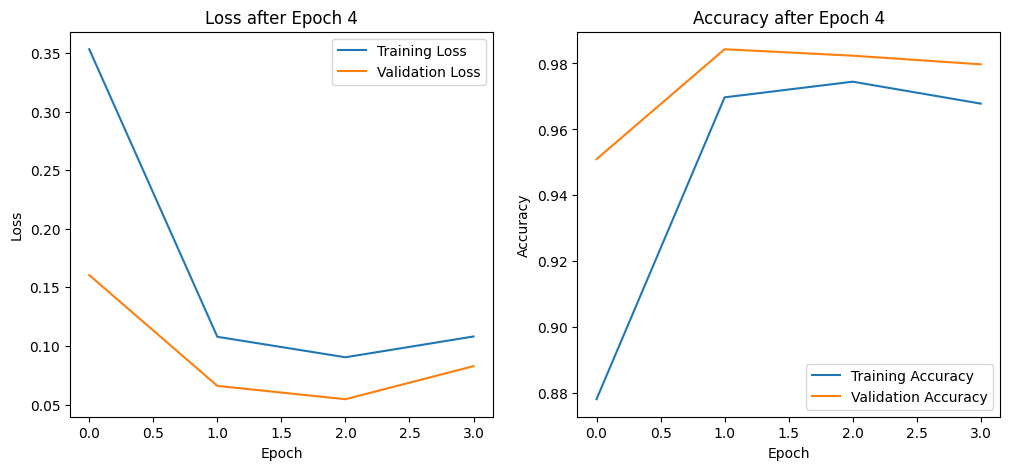

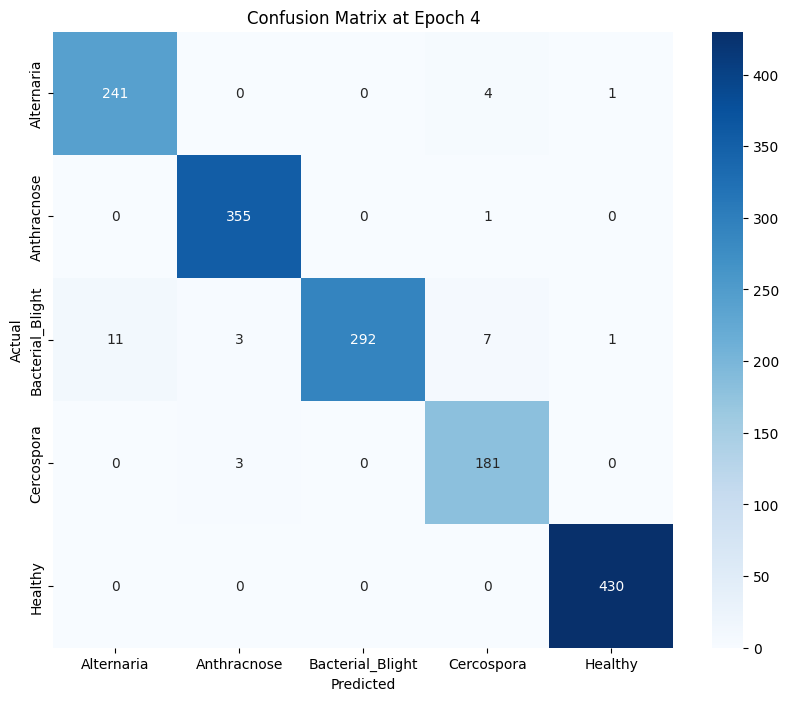

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_5.pth
Epoch : 5 Train Loss : 0.088233 Train Acc : 0.972340
Epoch 5/40 - Valid Loss: 0.1007, Accuracy: 0.9719, Precision: 0.9737, Recall: 0.9719, F1 Score: 0.9720


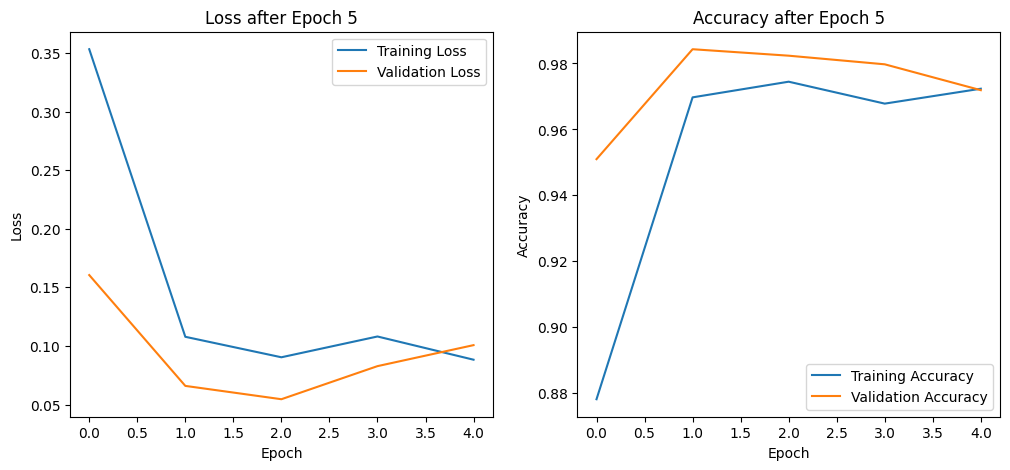

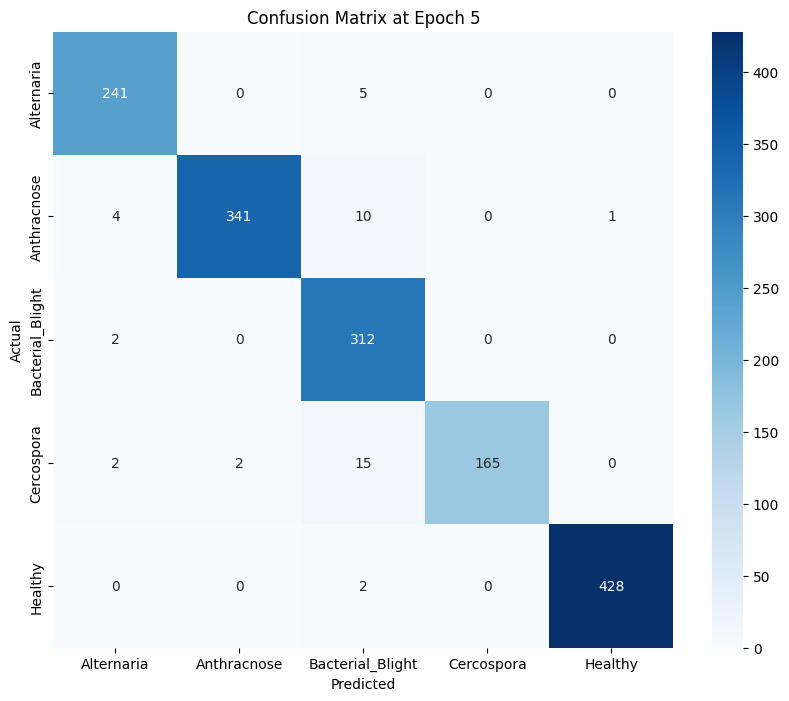

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_6.pth
Valid_loss decreased 0.05451354210252886 --> 0.032607990858302294
Epoch : 6 Train Loss : 0.049021 Train Acc : 0.982180
Epoch 6/40 - Valid Loss: 0.0326, Accuracy: 0.9895, Precision: 0.9896, Recall: 0.9895, F1 Score: 0.9895


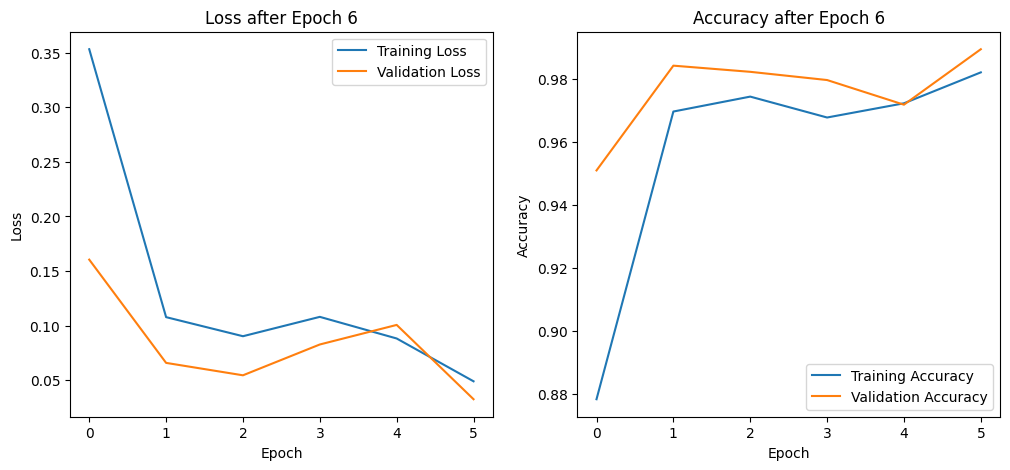

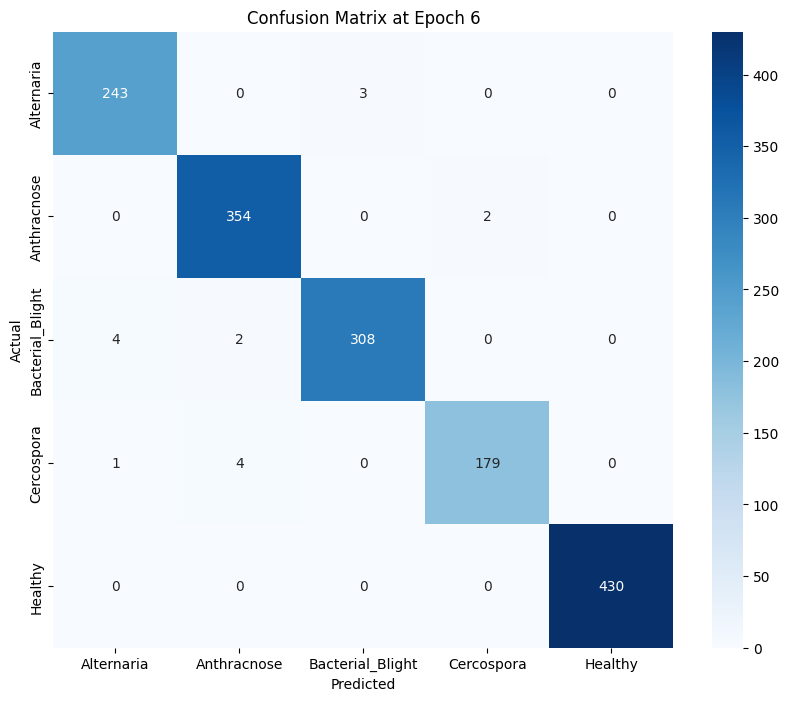

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_7.pth
Epoch : 7 Train Loss : 0.086558 Train Acc : 0.980585
Epoch 7/40 - Valid Loss: 0.9190, Accuracy: 0.6752, Precision: 0.8153, Recall: 0.6752, F1 Score: 0.6125


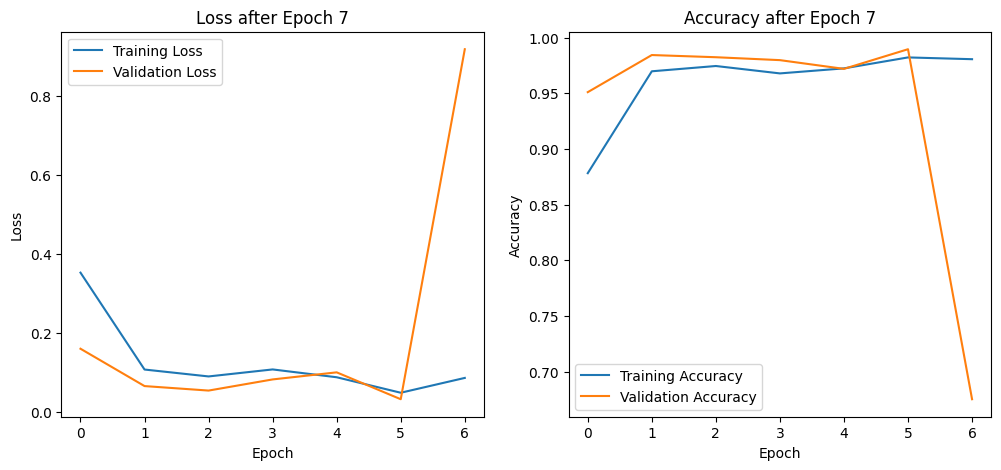

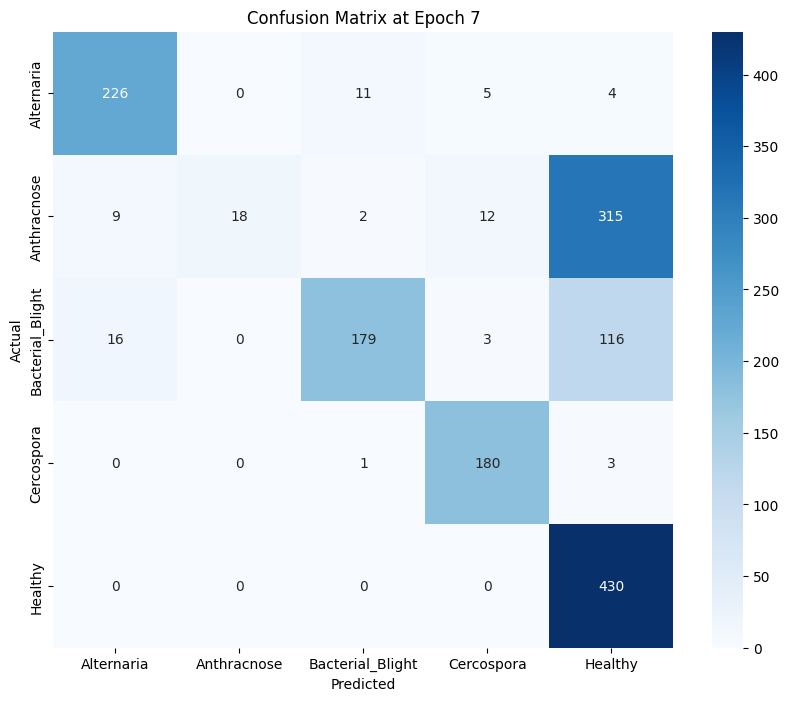

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_8.pth
Epoch : 8 Train Loss : 0.107052 Train Acc : 0.969680
Epoch 8/40 - Valid Loss: 0.0608, Accuracy: 0.9817, Precision: 0.9824, Recall: 0.9817, F1 Score: 0.9818


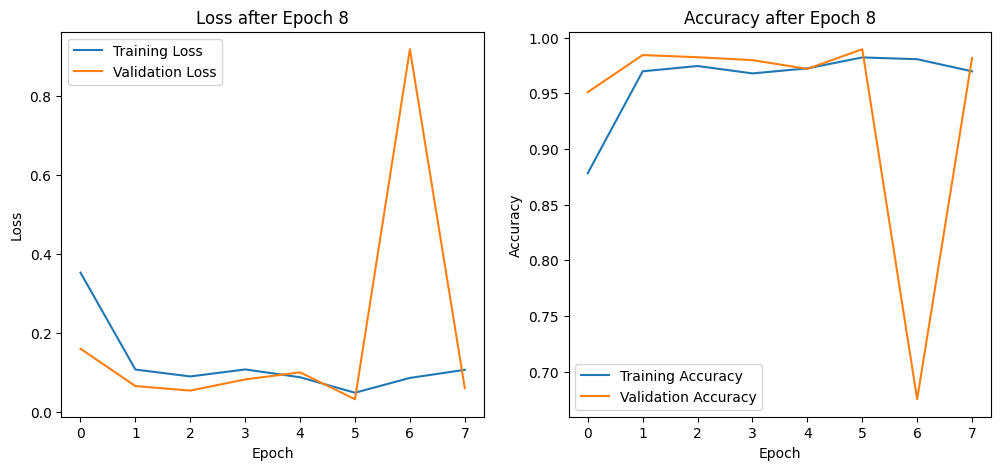

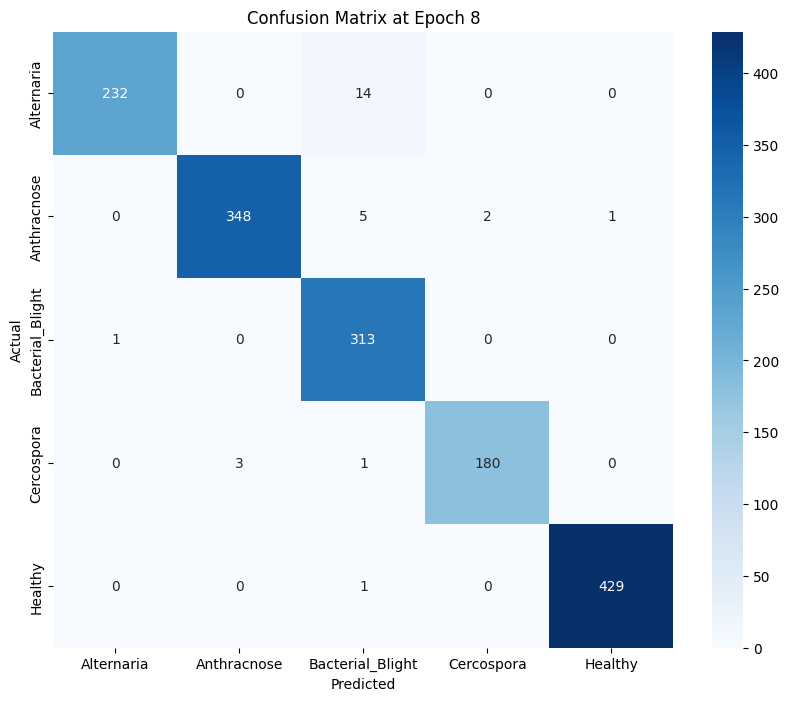

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_9.pth
Epoch : 9 Train Loss : 0.048961 Train Acc : 0.985904
Epoch 9/40 - Valid Loss: 0.0476, Accuracy: 0.9889, Precision: 0.9890, Recall: 0.9889, F1 Score: 0.9889


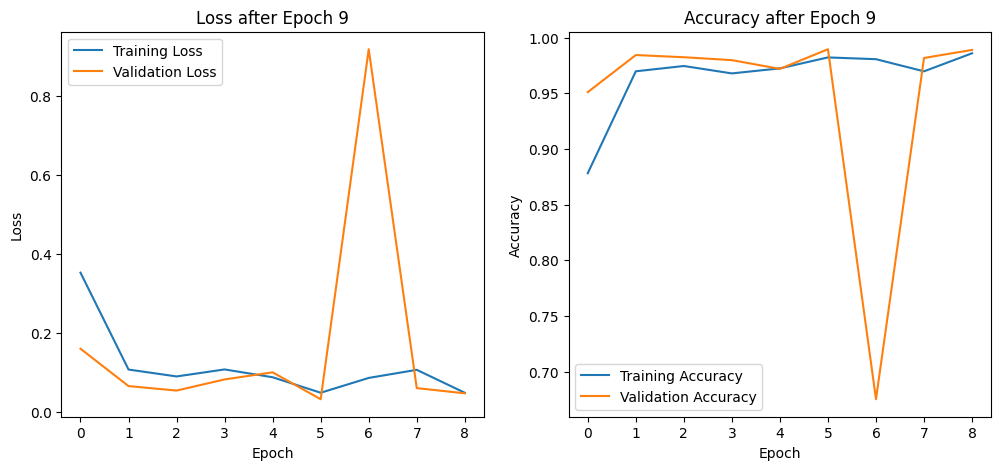

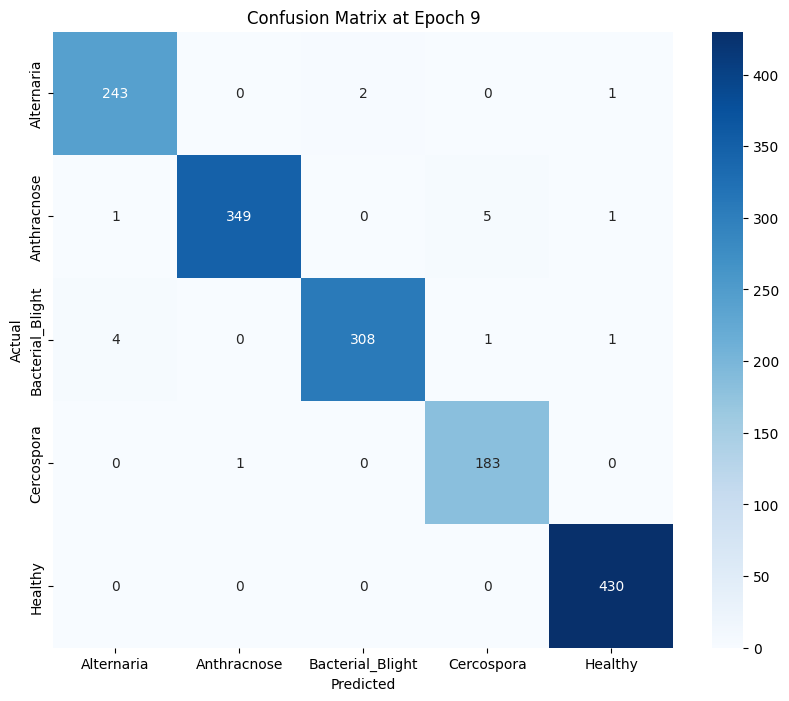

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_10.pth
Epoch : 10 Train Loss : 0.081390 Train Acc : 0.980053
Epoch 10/40 - Valid Loss: 0.0457, Accuracy: 0.9889, Precision: 0.9889, Recall: 0.9889, F1 Score: 0.9889


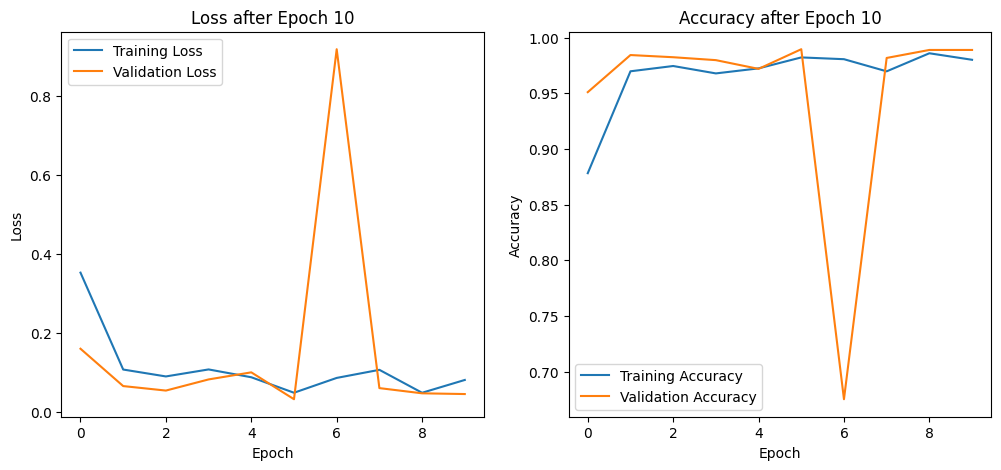

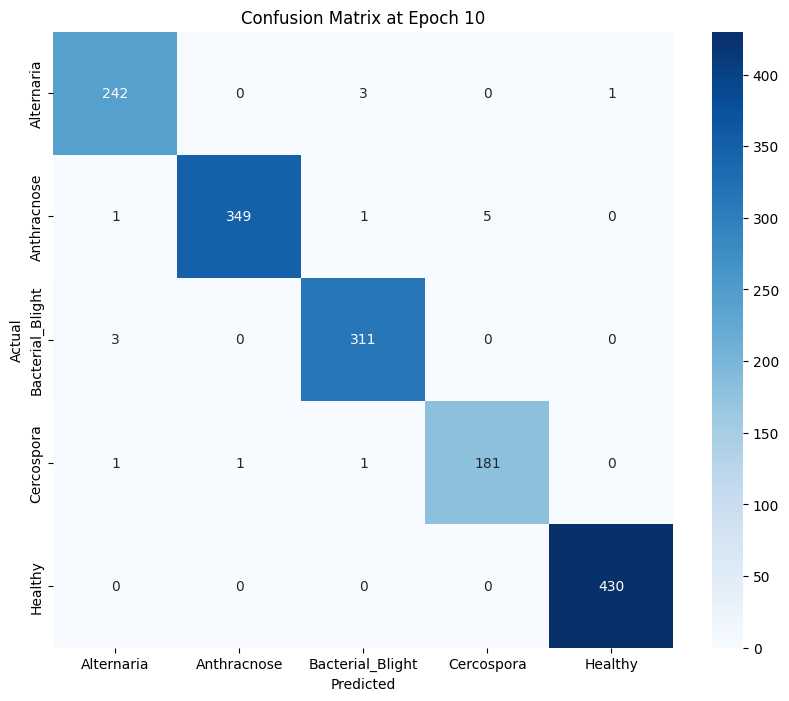

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_11.pth
Epoch : 11 Train Loss : 0.069017 Train Acc : 0.982712
Epoch 11/40 - Valid Loss: 0.0528, Accuracy: 0.9830, Precision: 0.9832, Recall: 0.9830, F1 Score: 0.9830


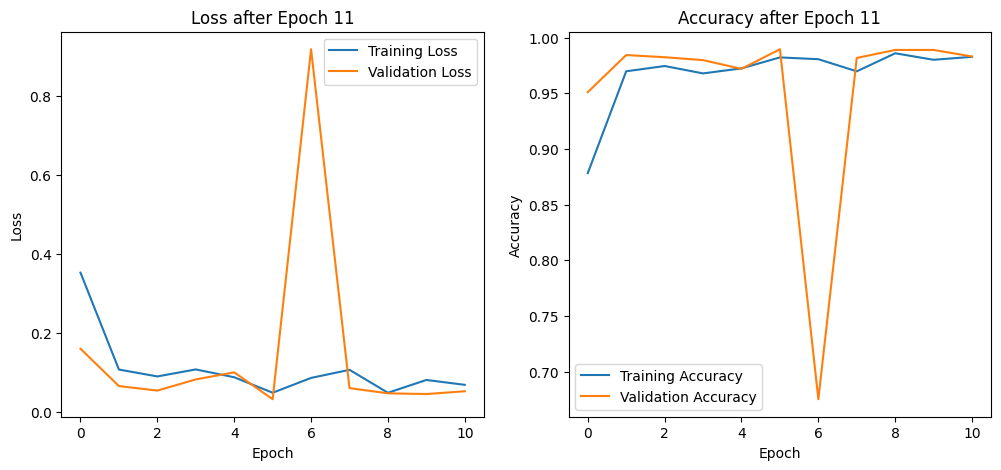

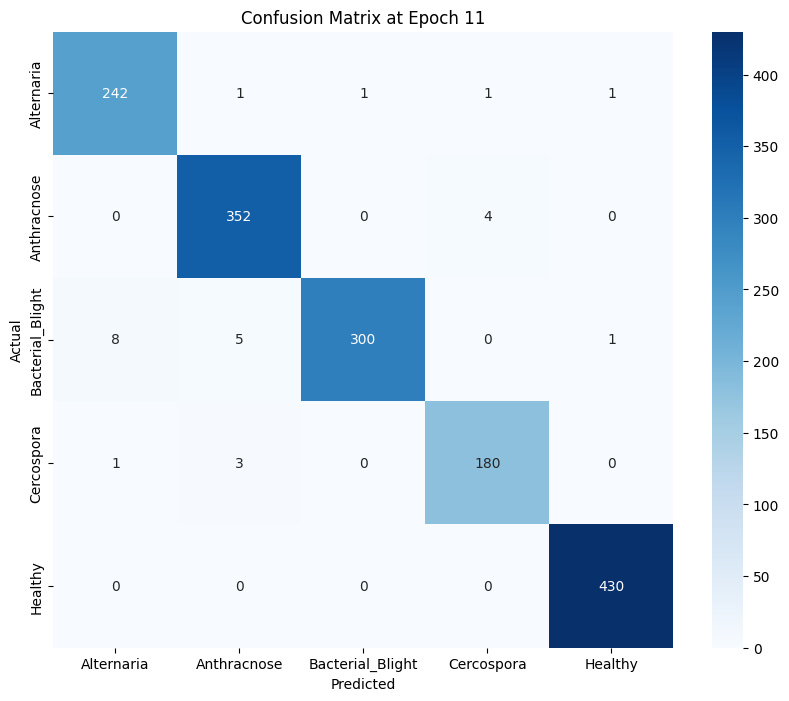

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_12.pth
Epoch : 12 Train Loss : 0.087919 Train Acc : 0.976101
Epoch 12/40 - Valid Loss: 0.0495, Accuracy: 0.9824, Precision: 0.9825, Recall: 0.9824, F1 Score: 0.9823


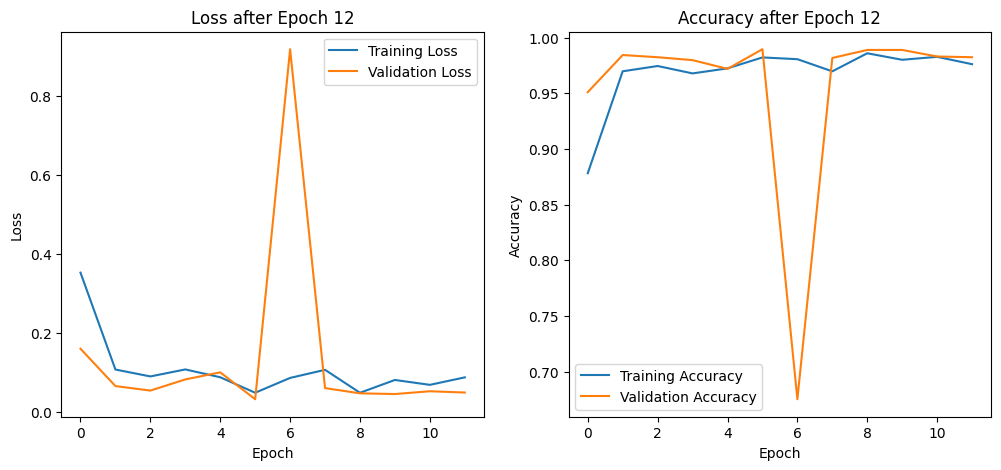

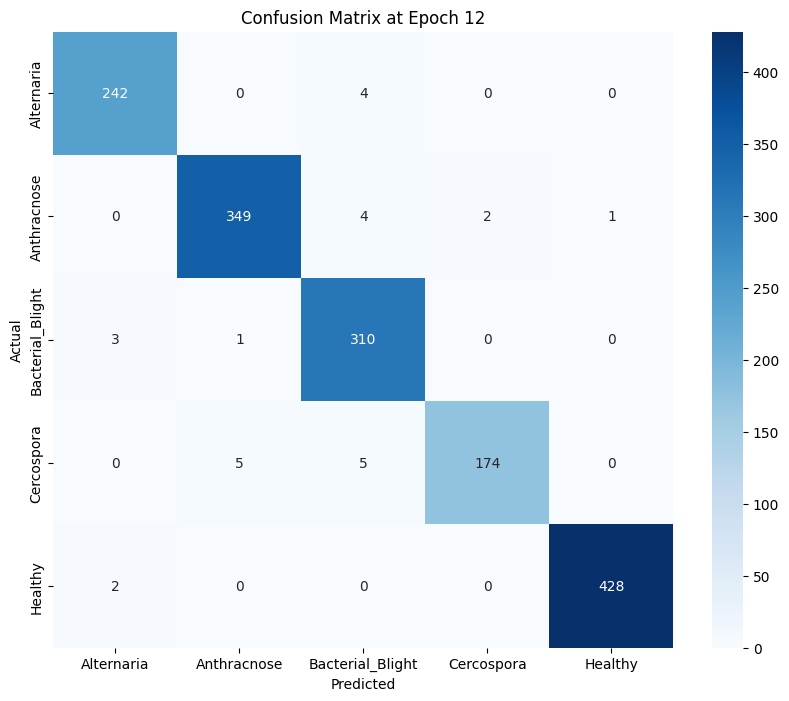

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_13.pth
Epoch : 13 Train Loss : 0.050589 Train Acc : 0.985638
Epoch 13/40 - Valid Loss: 0.0484, Accuracy: 0.9876, Precision: 0.9877, Recall: 0.9876, F1 Score: 0.9876


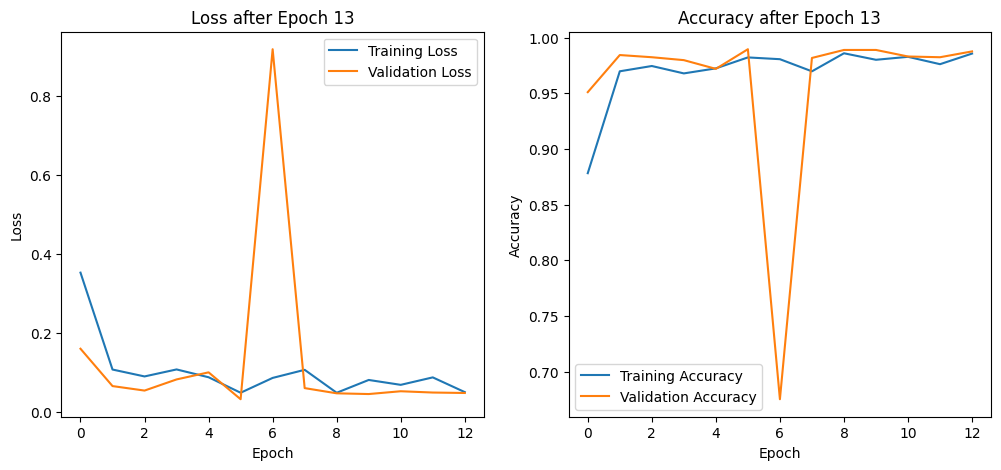

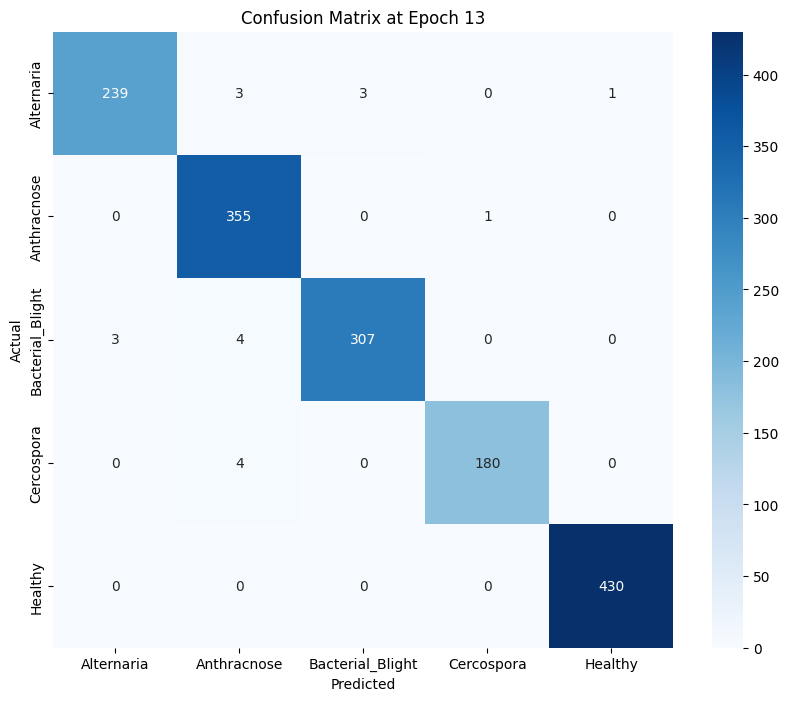

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_14.pth
Epoch : 14 Train Loss : 0.042761 Train Acc : 0.986436
Epoch 14/40 - Valid Loss: 0.2161, Accuracy: 0.9503, Precision: 0.9598, Recall: 0.9503, F1 Score: 0.9515


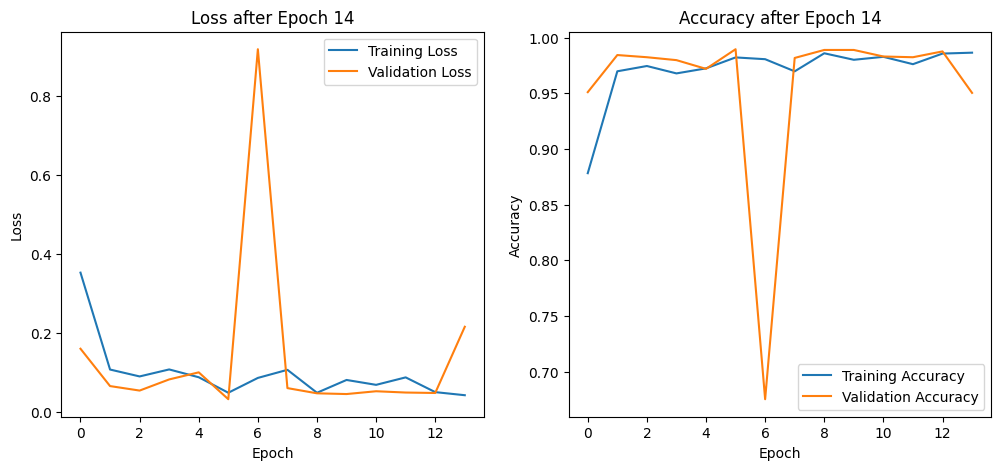

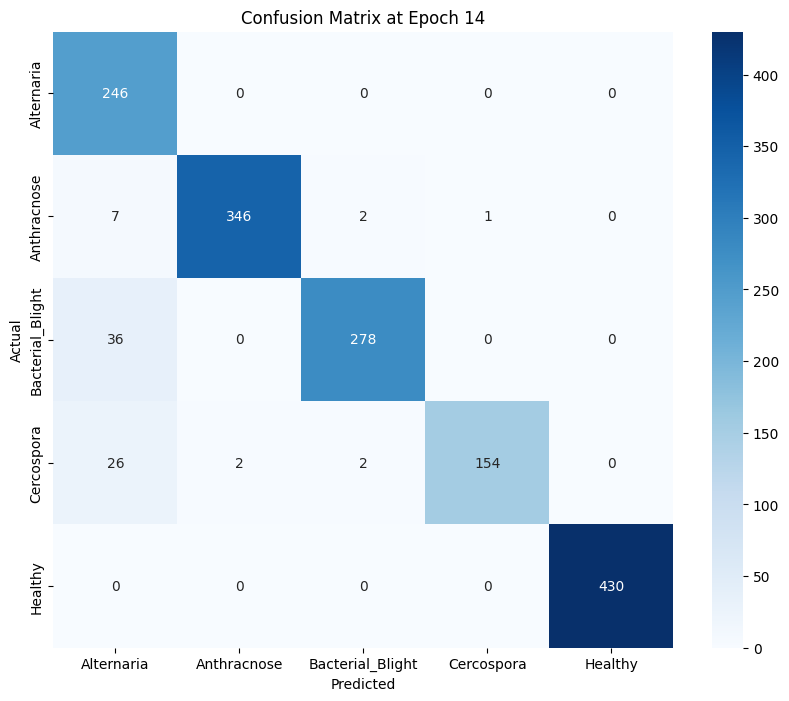

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_15.pth
Epoch : 15 Train Loss : 0.044281 Train Acc : 0.986968
Epoch 15/40 - Valid Loss: 0.0532, Accuracy: 0.9804, Precision: 0.9808, Recall: 0.9804, F1 Score: 0.9804


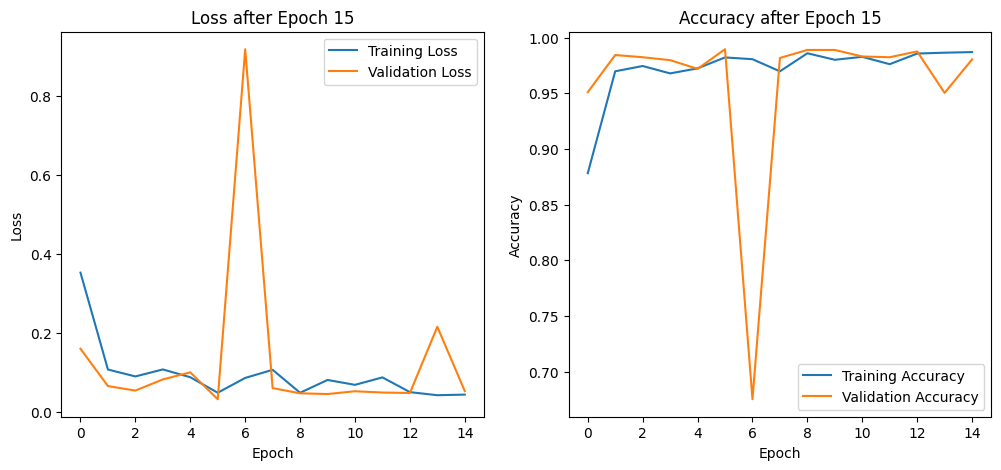

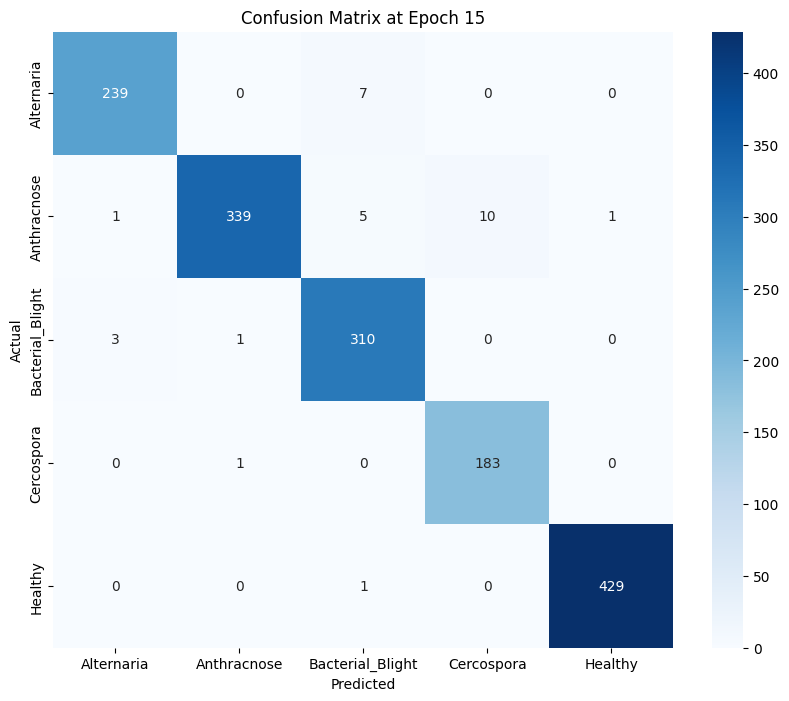

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_16.pth
Epoch : 16 Train Loss : 0.054309 Train Acc : 0.984612
Epoch 16/40 - Valid Loss: 0.0403, Accuracy: 0.9843, Precision: 0.9844, Recall: 0.9843, F1 Score: 0.9843


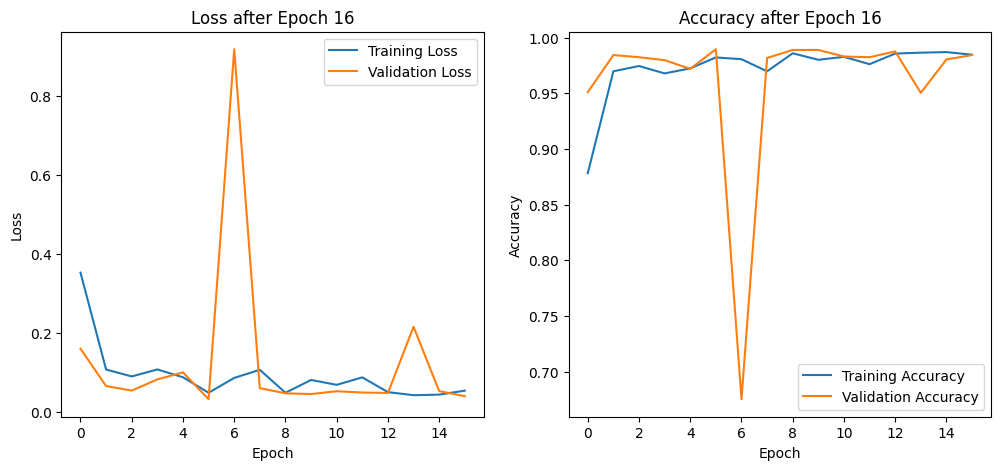

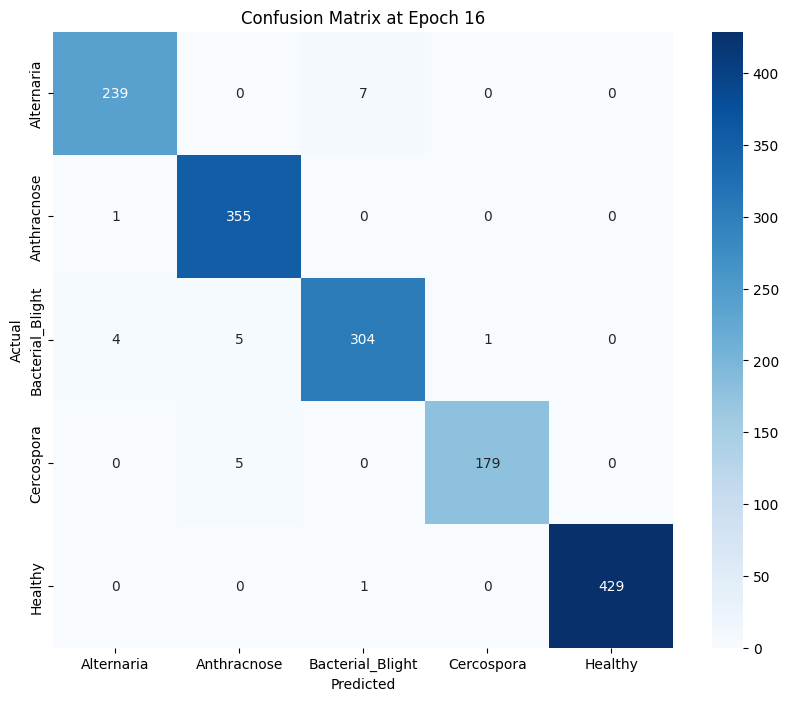

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_17.pth
Epoch : 17 Train Loss : 0.049499 Train Acc : 0.985106
Epoch 17/40 - Valid Loss: 0.0574, Accuracy: 0.9810, Precision: 0.9813, Recall: 0.9810, F1 Score: 0.9809


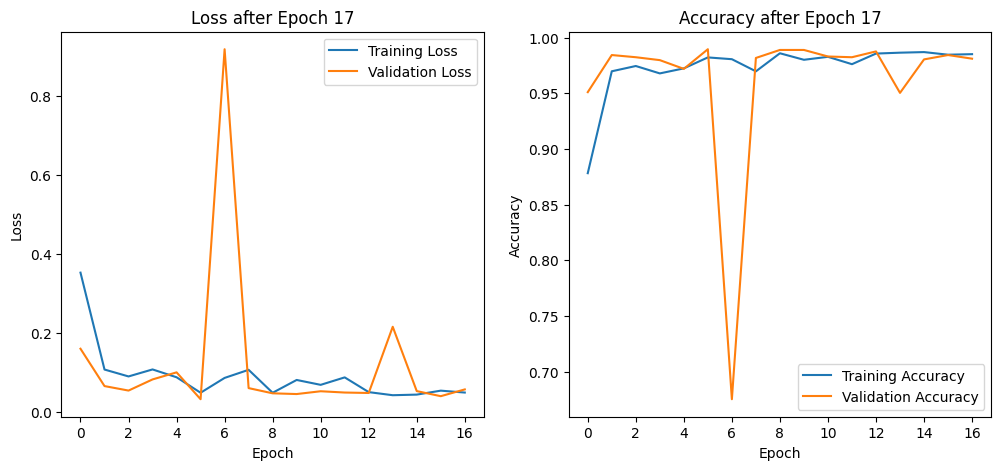

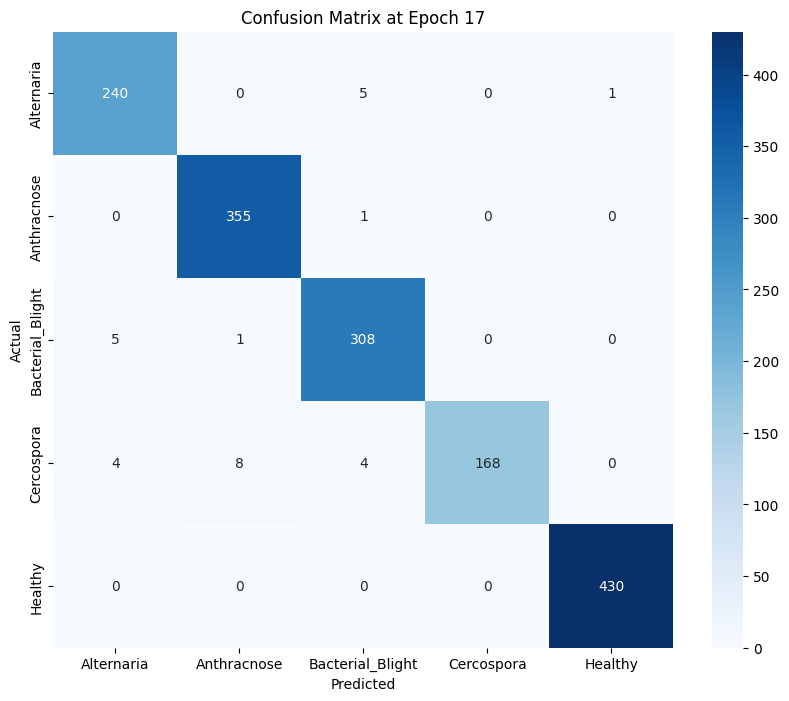

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_18.pth
Valid_loss decreased 0.032607990858302294 --> 0.027829497657994463
Epoch : 18 Train Loss : 0.012823 Train Acc : 0.997074
Epoch 18/40 - Valid Loss: 0.0278, Accuracy: 0.9908, Precision: 0.9909, Recall: 0.9908, F1 Score: 0.9908


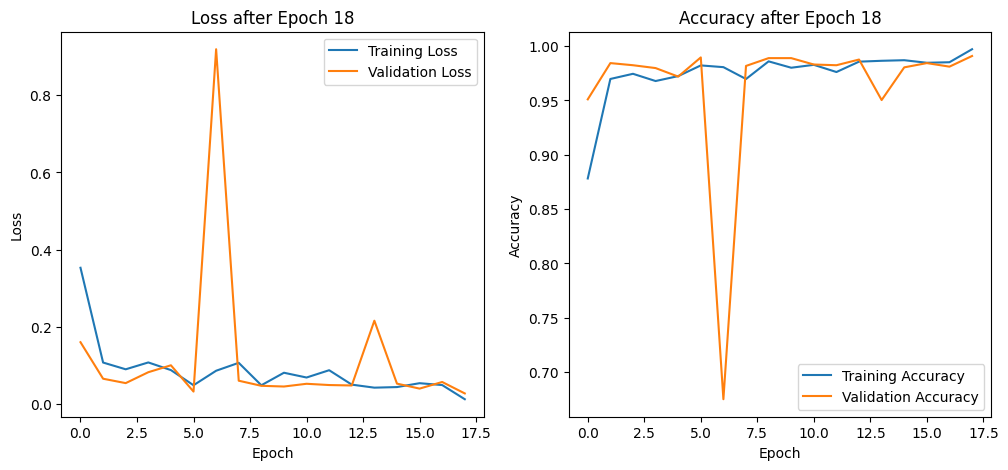

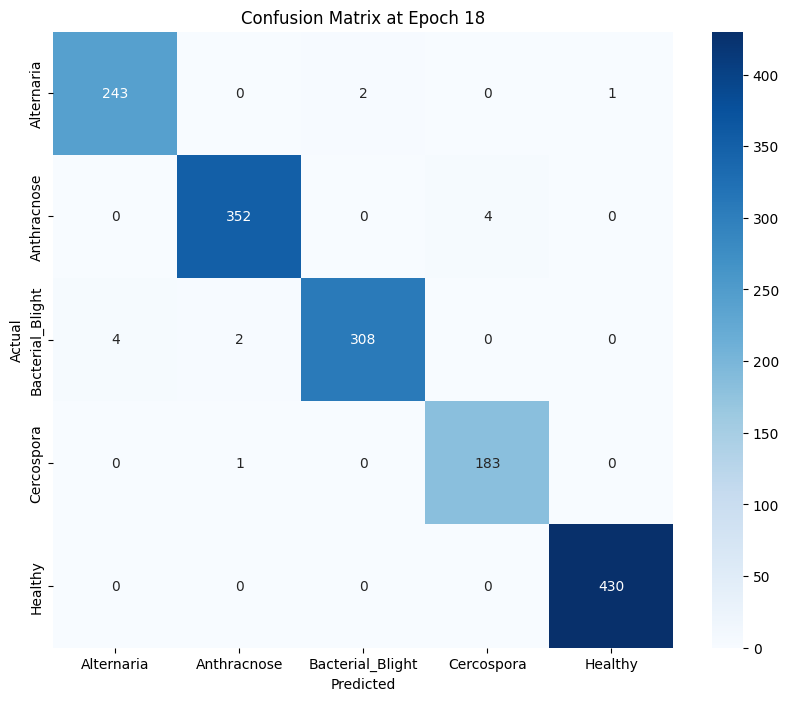

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_19.pth
Epoch : 19 Train Loss : 0.004866 Train Acc : 0.998404
Epoch 19/40 - Valid Loss: 0.0293, Accuracy: 0.9915, Precision: 0.9916, Recall: 0.9915, F1 Score: 0.9915


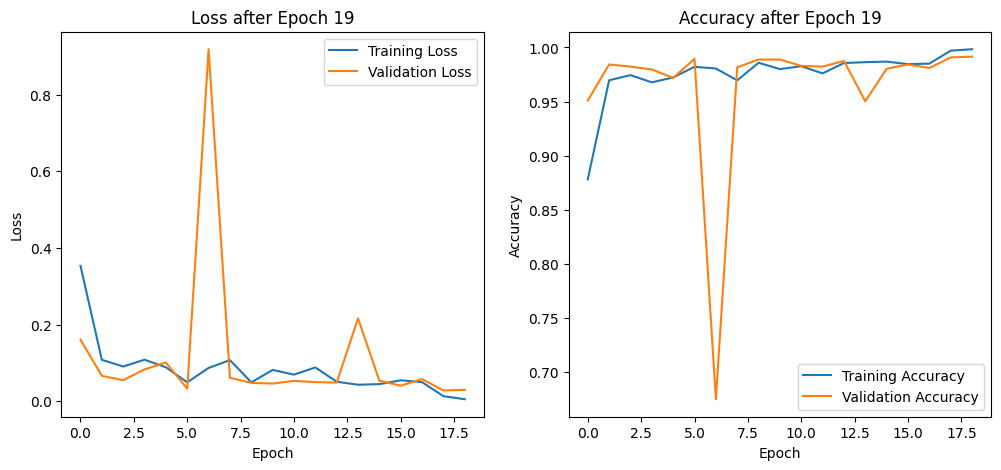

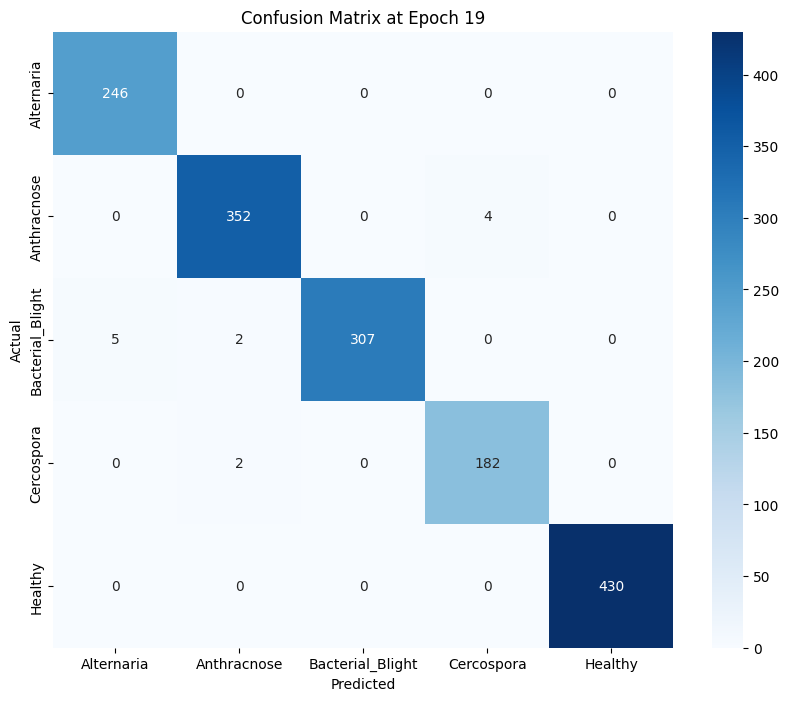

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_20.pth
Epoch : 20 Train Loss : 0.002791 Train Acc : 0.999468
Epoch 20/40 - Valid Loss: 0.0281, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


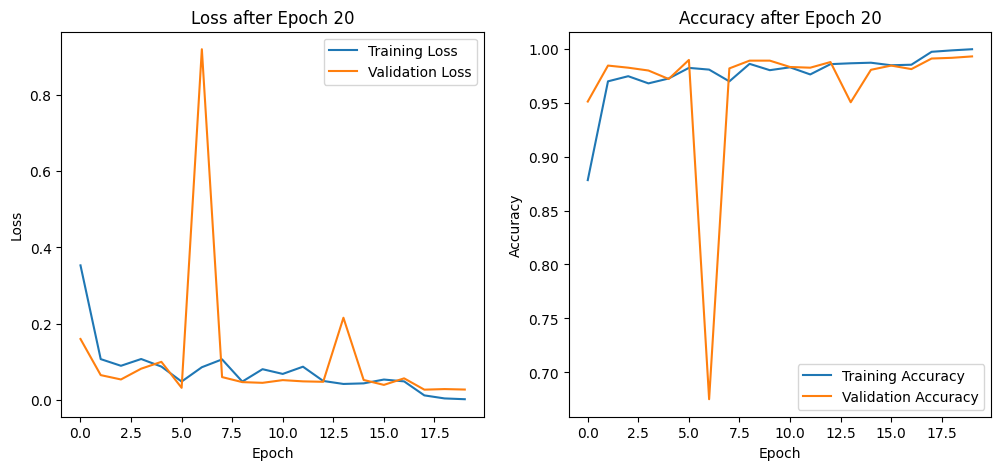

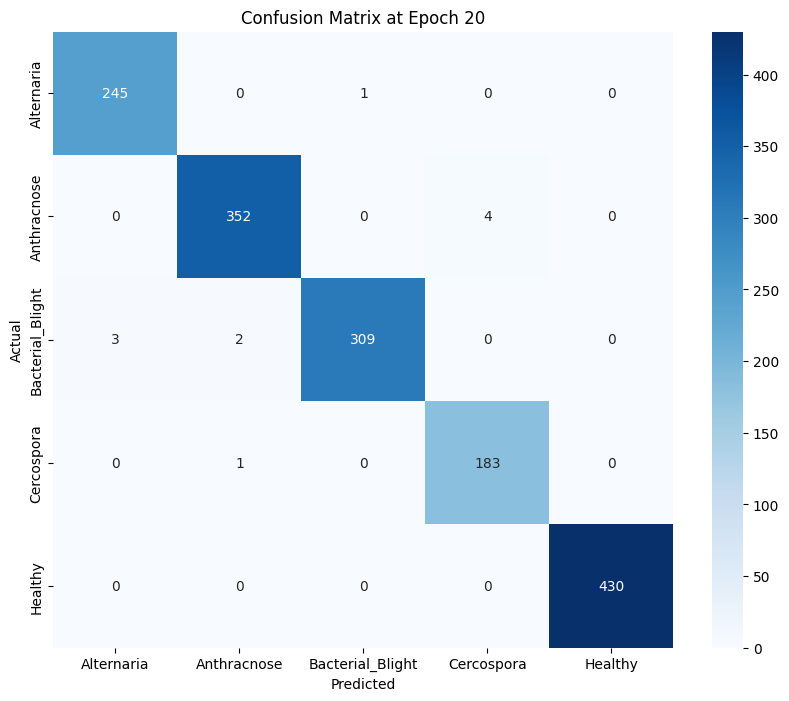

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_21.pth
Epoch : 21 Train Loss : 0.001423 Train Acc : 0.999734
Epoch 21/40 - Valid Loss: 0.0318, Accuracy: 0.9915, Precision: 0.9916, Recall: 0.9915, F1 Score: 0.9915


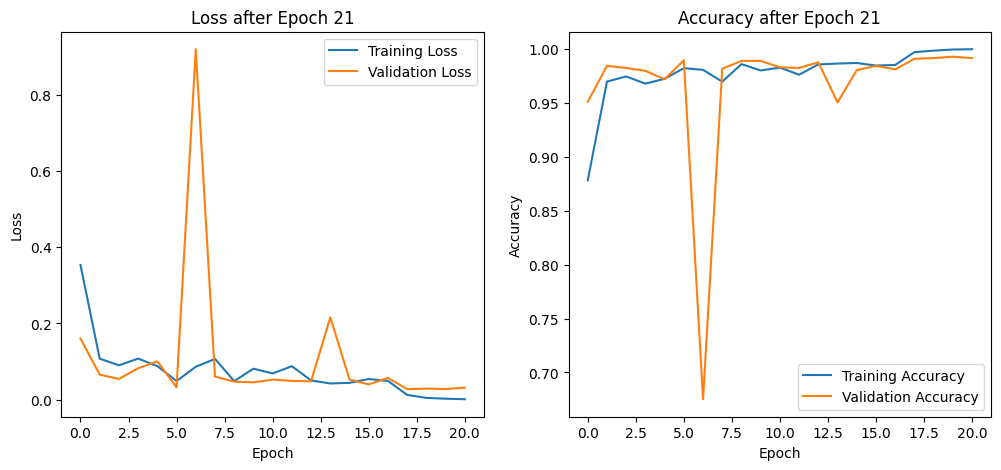

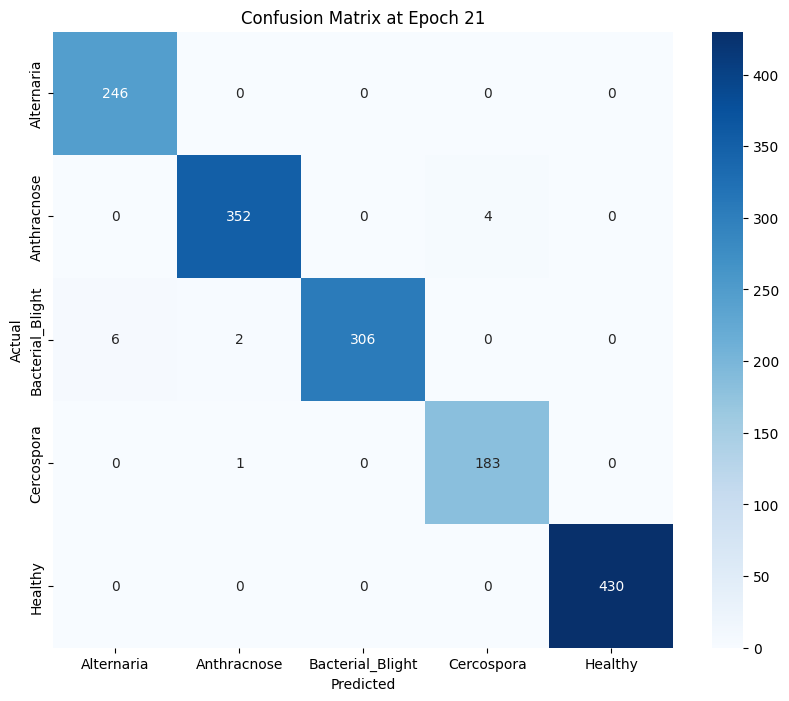

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_22.pth
Epoch : 22 Train Loss : 0.001703 Train Acc : 0.999468
Epoch 22/40 - Valid Loss: 0.0299, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


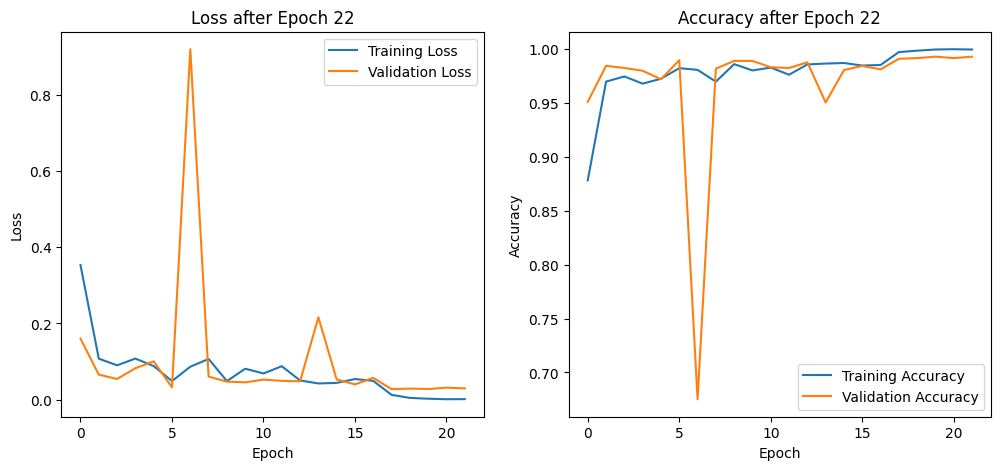

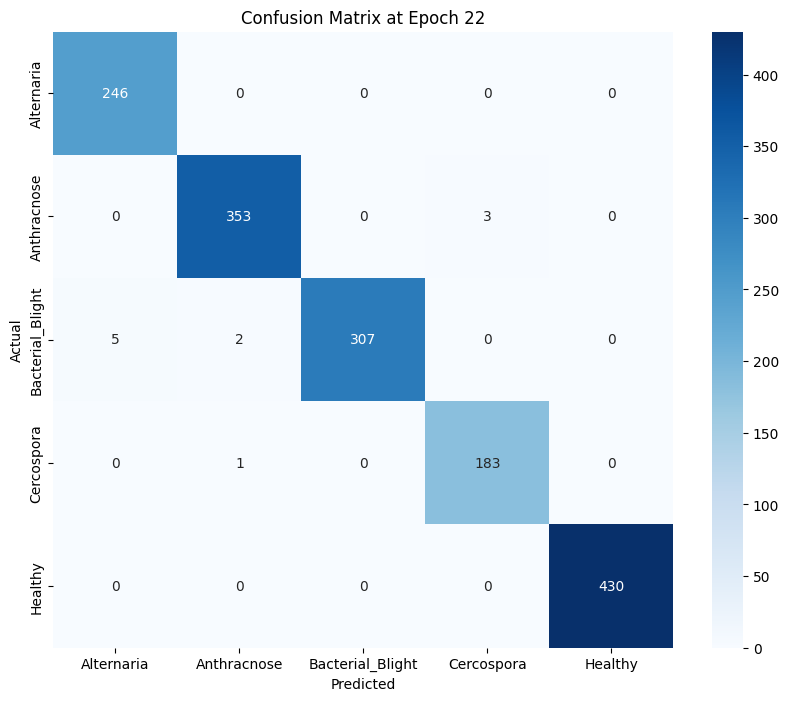

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_23.pth
Epoch : 23 Train Loss : 0.001136 Train Acc : 0.999734
Epoch 23/40 - Valid Loss: 0.0299, Accuracy: 0.9935, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


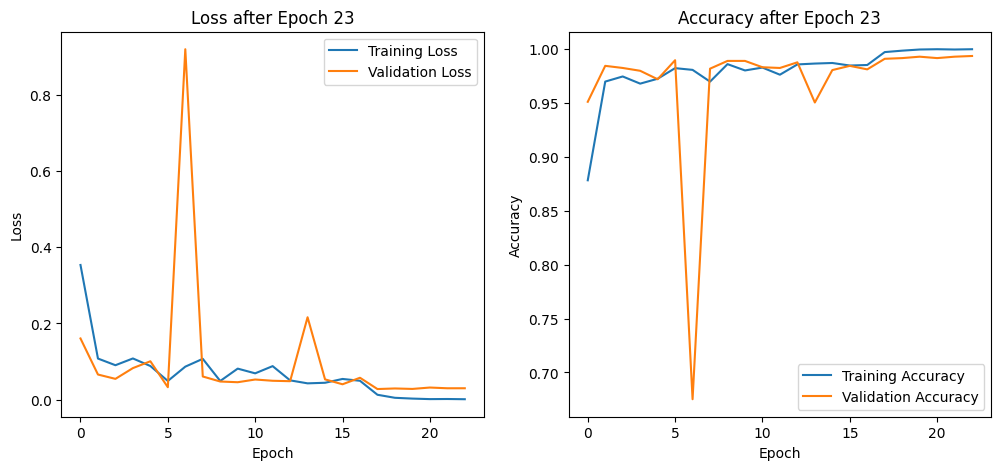

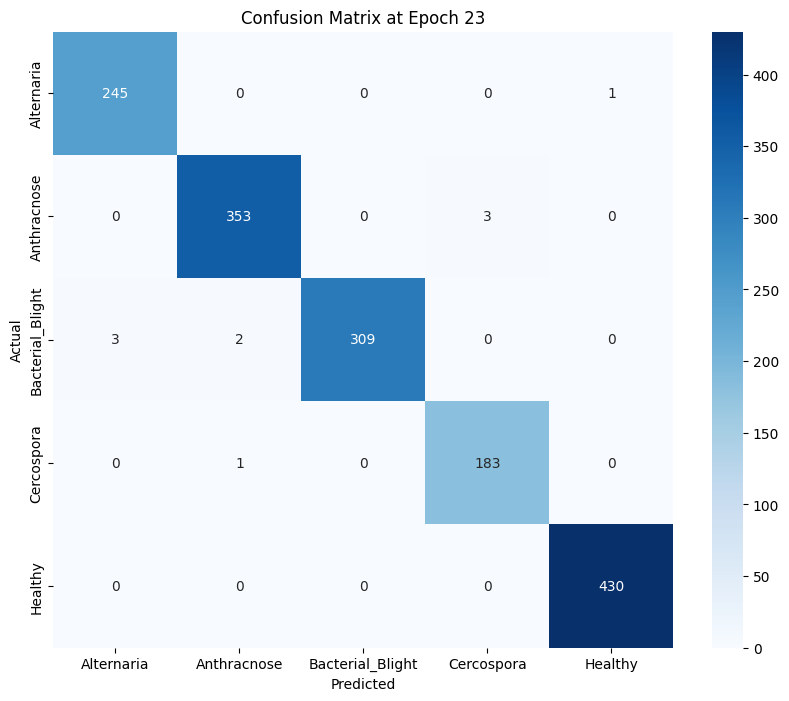

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_24.pth
Epoch : 24 Train Loss : 0.001246 Train Acc : 0.999468
Epoch 24/40 - Valid Loss: 0.0312, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


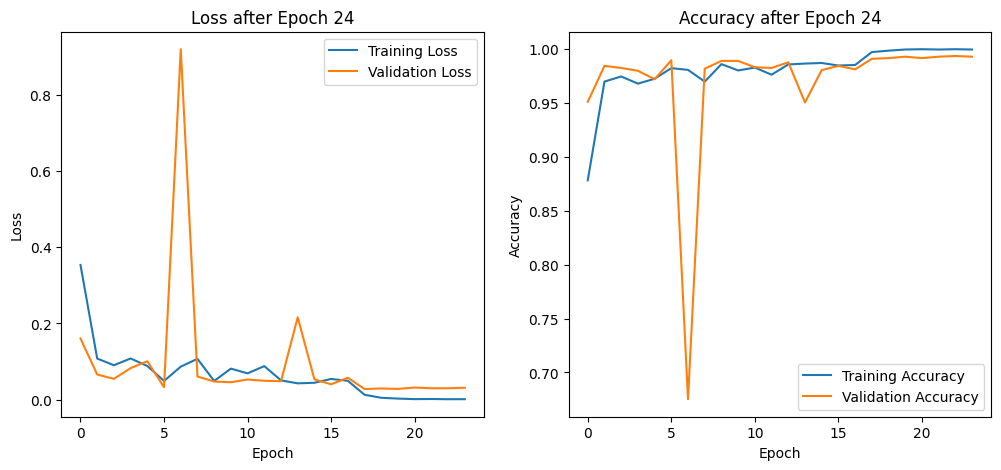

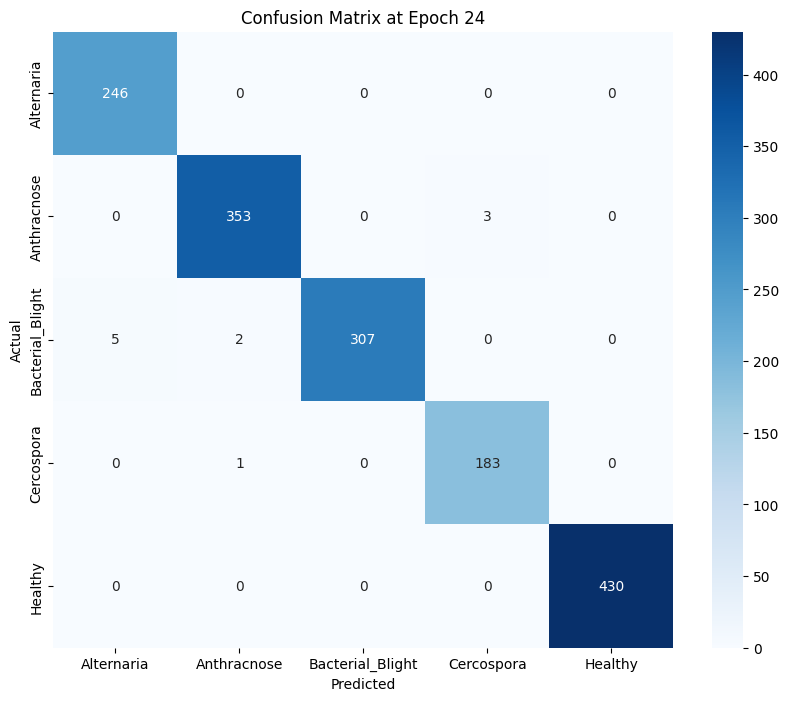

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_25.pth
Epoch : 25 Train Loss : 0.000508 Train Acc : 1.000000
Epoch 25/40 - Valid Loss: 0.0314, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


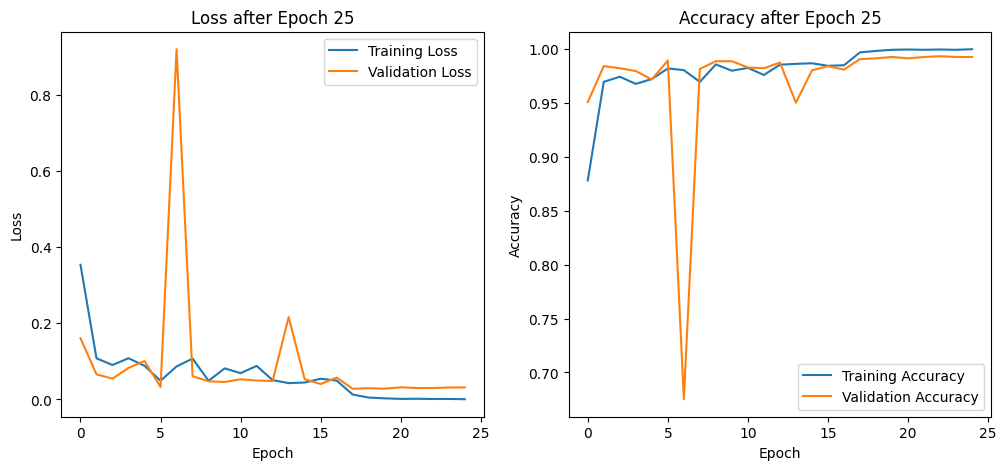

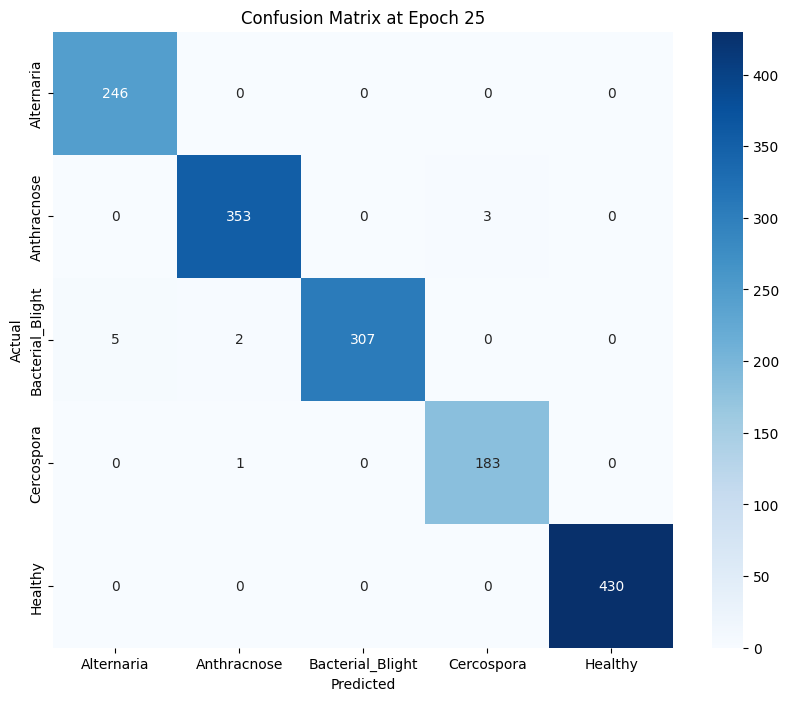

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_26.pth
Epoch : 26 Train Loss : 0.000408 Train Acc : 1.000000
Epoch 26/40 - Valid Loss: 0.0313, Accuracy: 0.9922, Precision: 0.9922, Recall: 0.9922, F1 Score: 0.9922


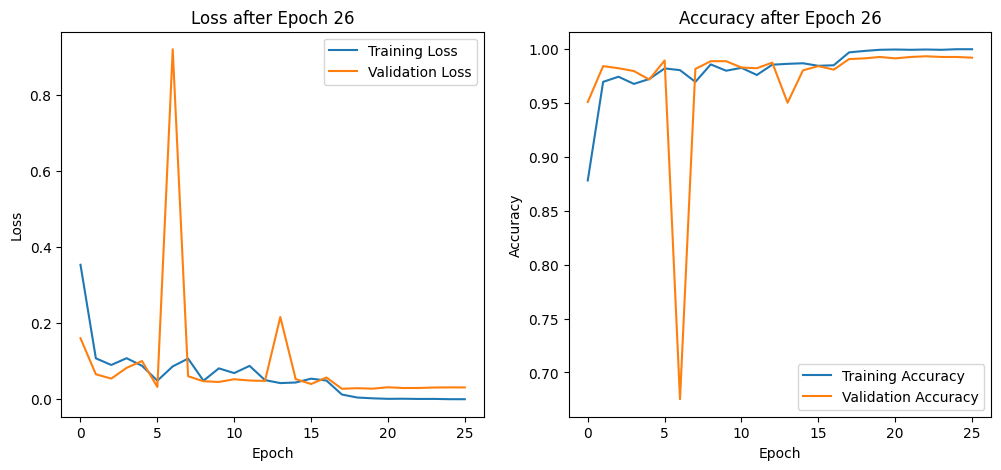

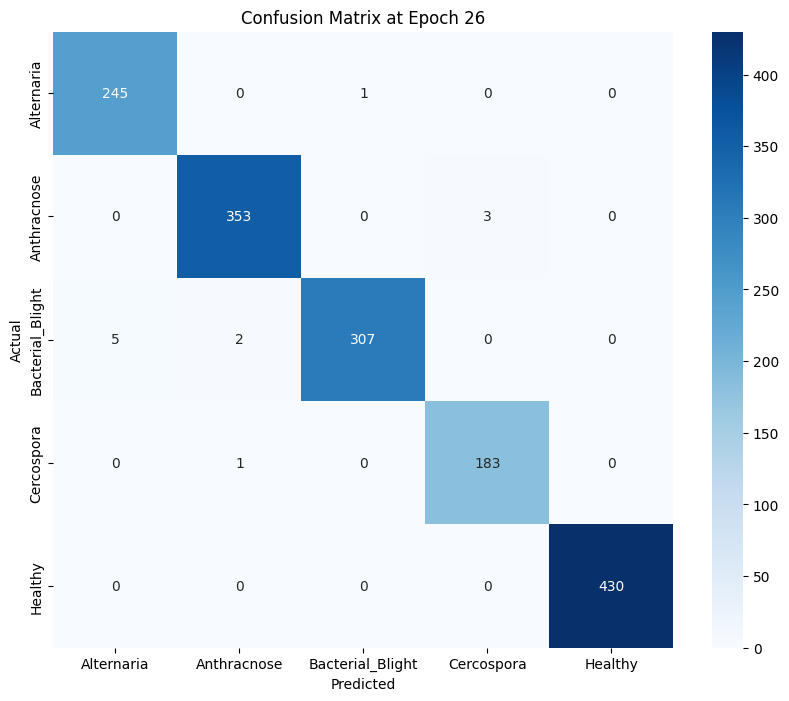

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_27.pth
Epoch : 27 Train Loss : 0.001731 Train Acc : 0.999468
Epoch 27/40 - Valid Loss: 0.0493, Accuracy: 0.9908, Precision: 0.9910, Recall: 0.9908, F1 Score: 0.9908


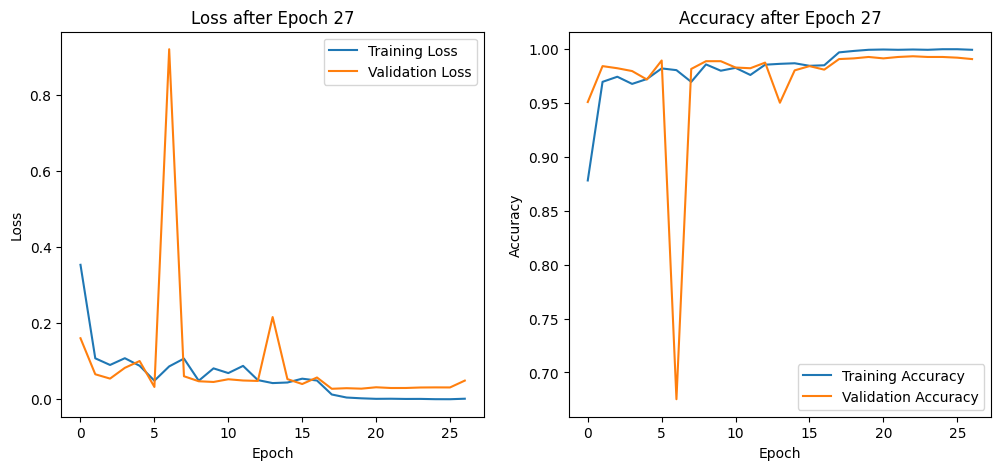

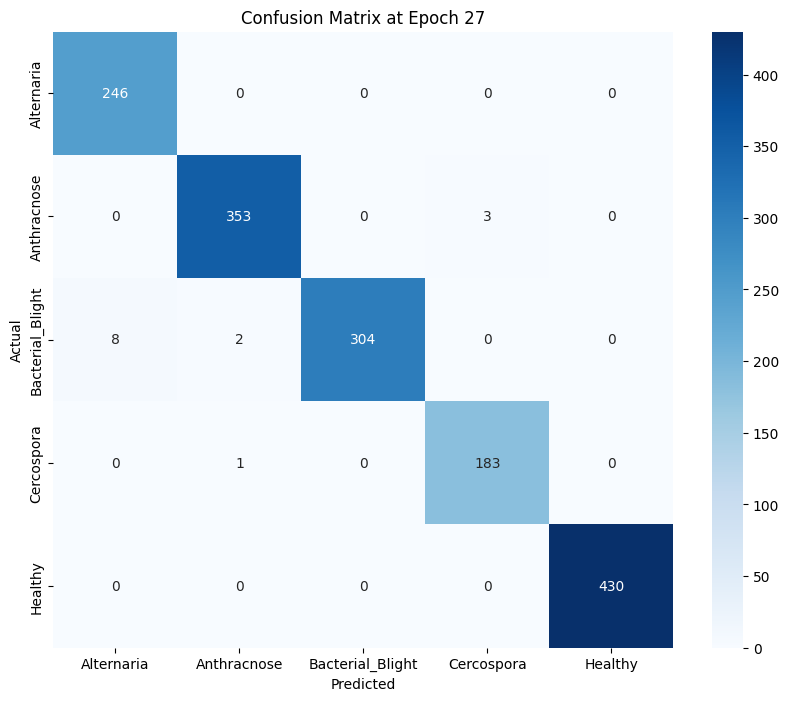

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_28.pth
Epoch : 28 Train Loss : 0.001607 Train Acc : 0.999734
Epoch 28/40 - Valid Loss: 0.0310, Accuracy: 0.9928, Precision: 0.9928, Recall: 0.9928, F1 Score: 0.9928


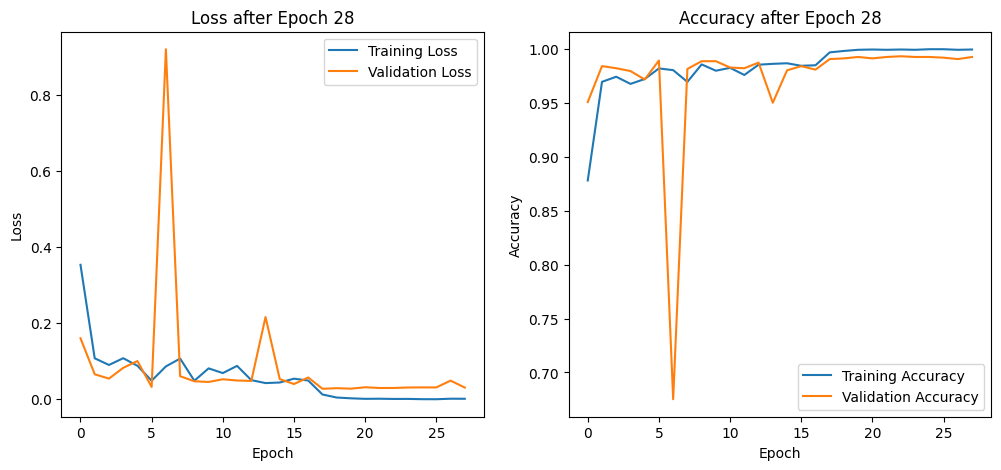

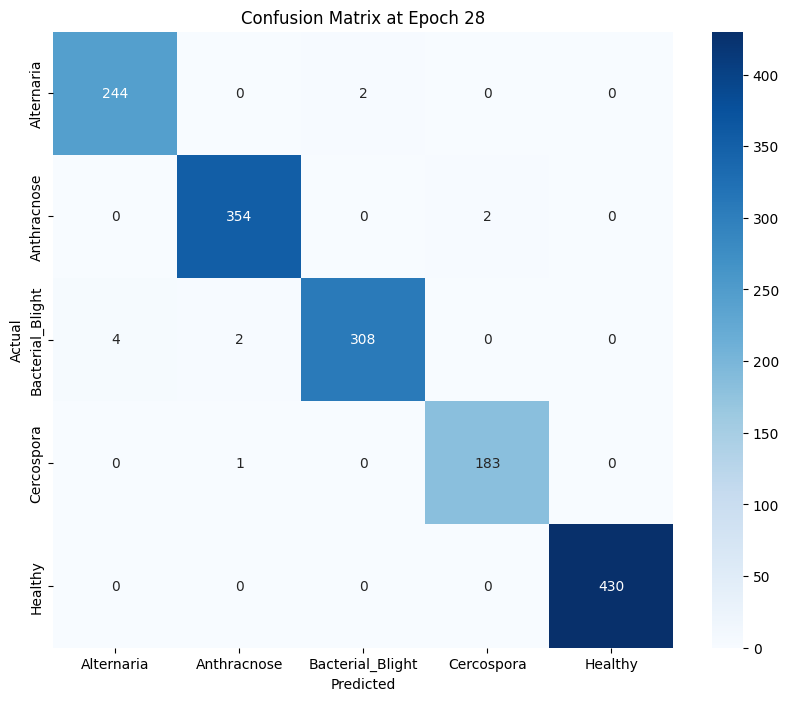

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_29.pth
Epoch : 29 Train Loss : 0.000811 Train Acc : 0.999734
Epoch 29/40 - Valid Loss: 0.0366, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


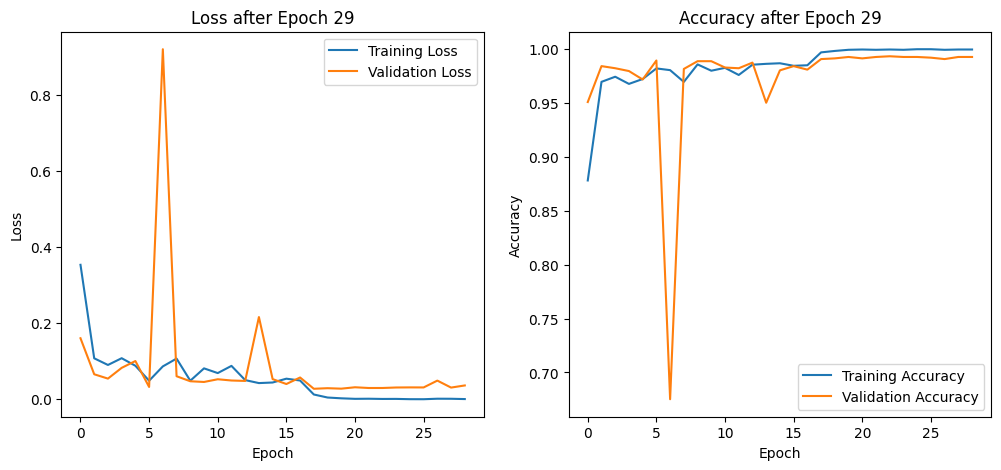

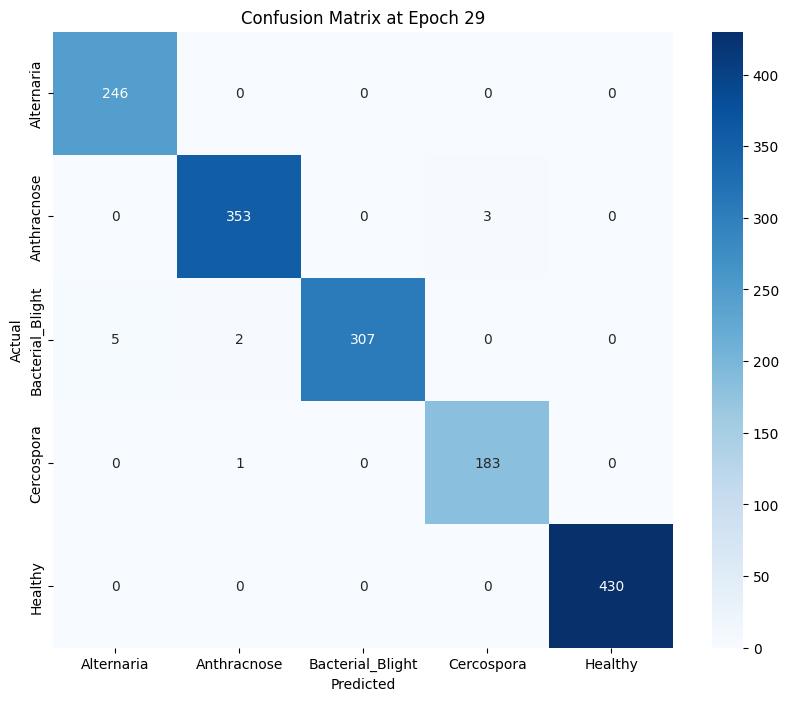

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_30.pth
Epoch : 30 Train Loss : 0.000536 Train Acc : 0.999734
Epoch 30/40 - Valid Loss: 0.0360, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


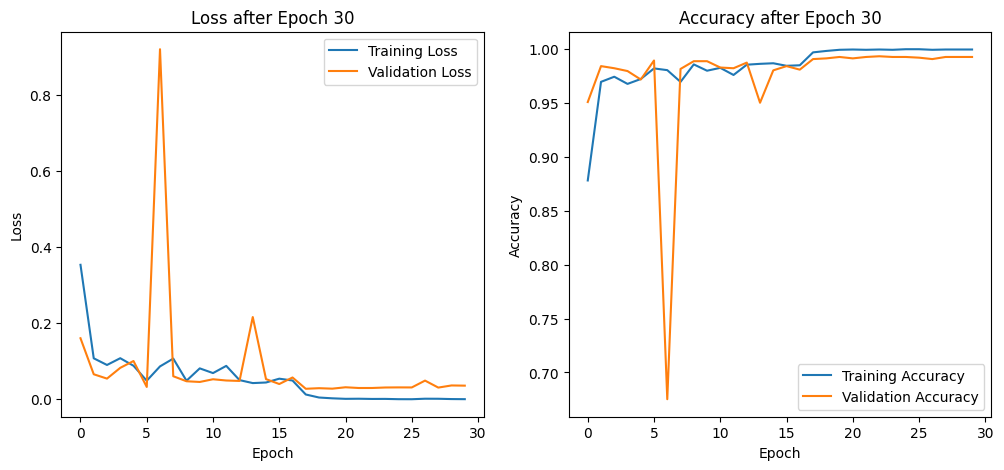

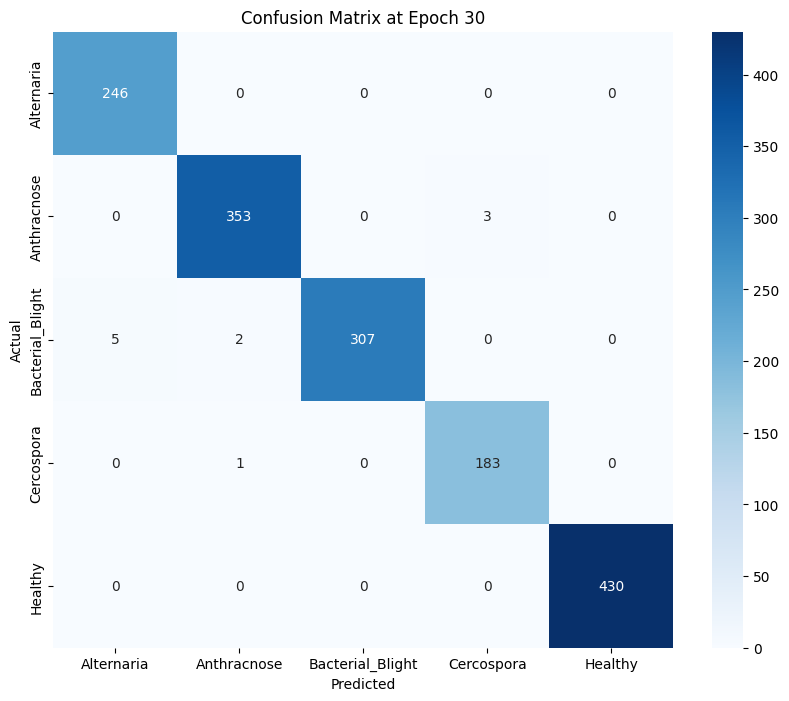

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_31.pth
Epoch : 31 Train Loss : 0.000321 Train Acc : 1.000000
Epoch 31/40 - Valid Loss: 0.0355, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


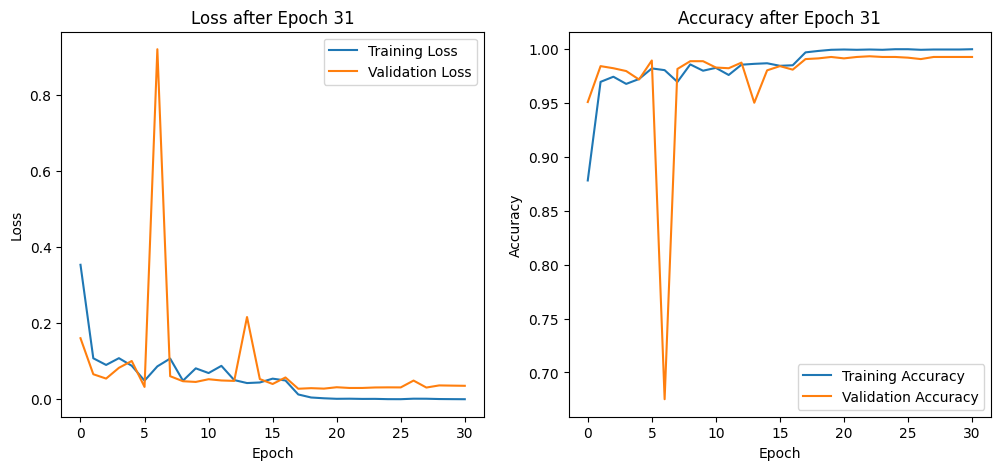

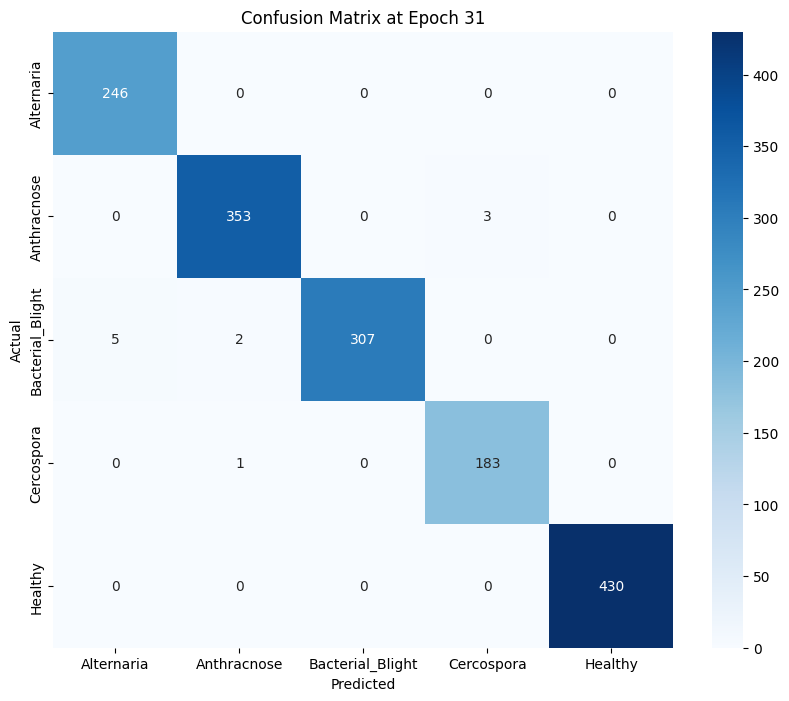

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_32.pth
Epoch : 32 Train Loss : 0.000306 Train Acc : 1.000000
Epoch 32/40 - Valid Loss: 0.0359, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


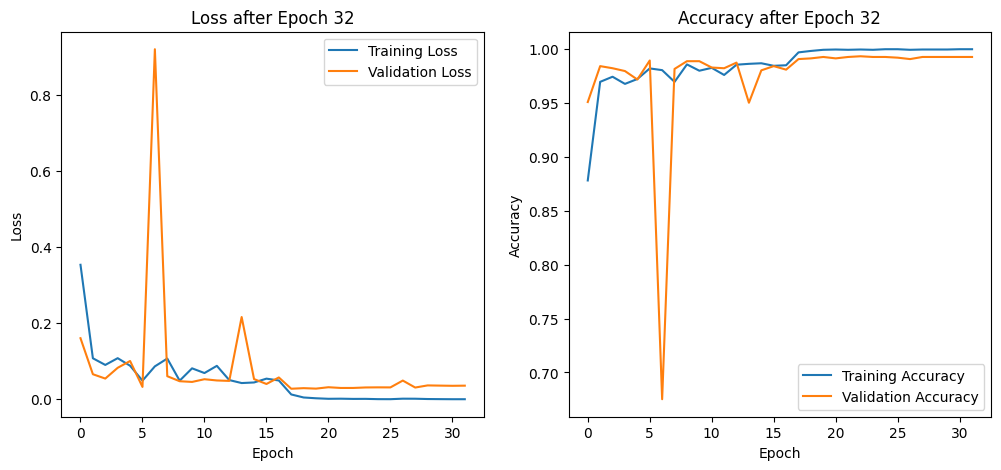

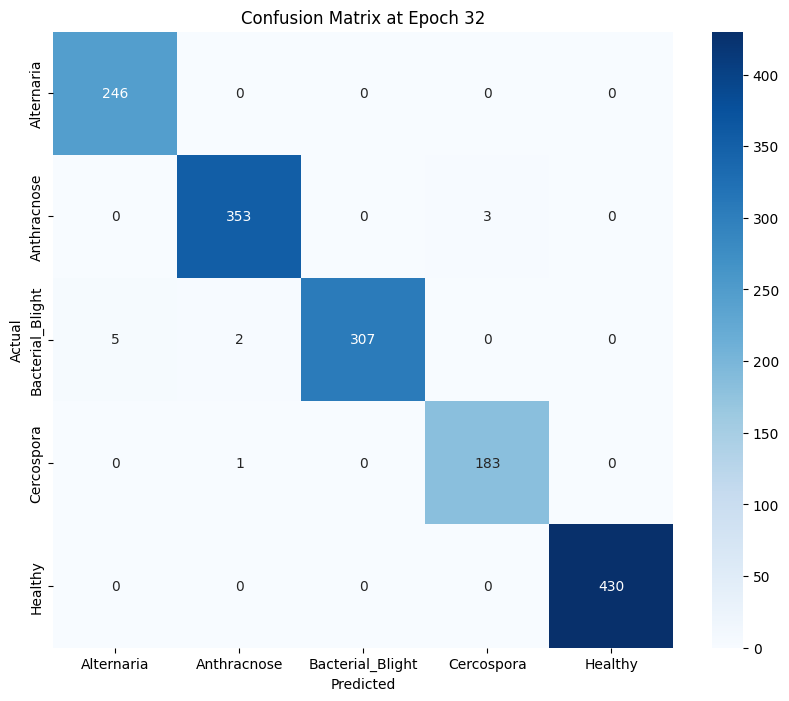

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_33.pth
Epoch : 33 Train Loss : 0.000230 Train Acc : 1.000000
Epoch 33/40 - Valid Loss: 0.0358, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


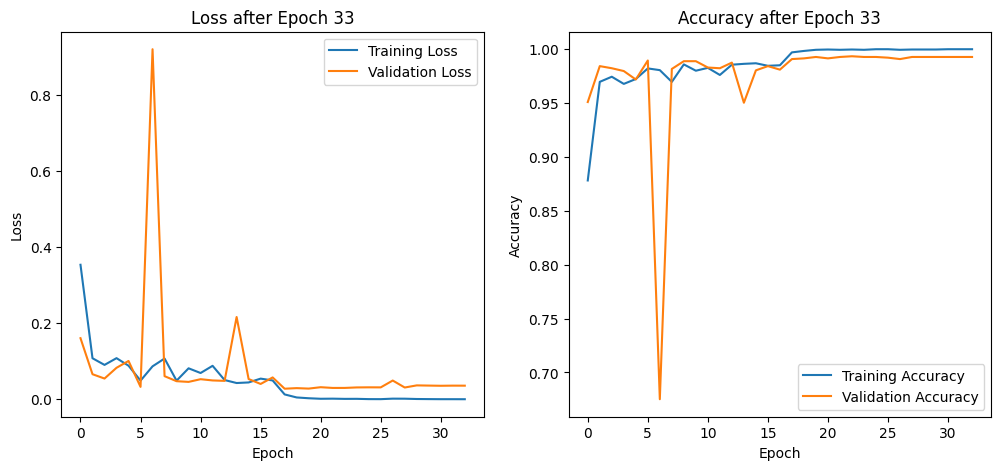

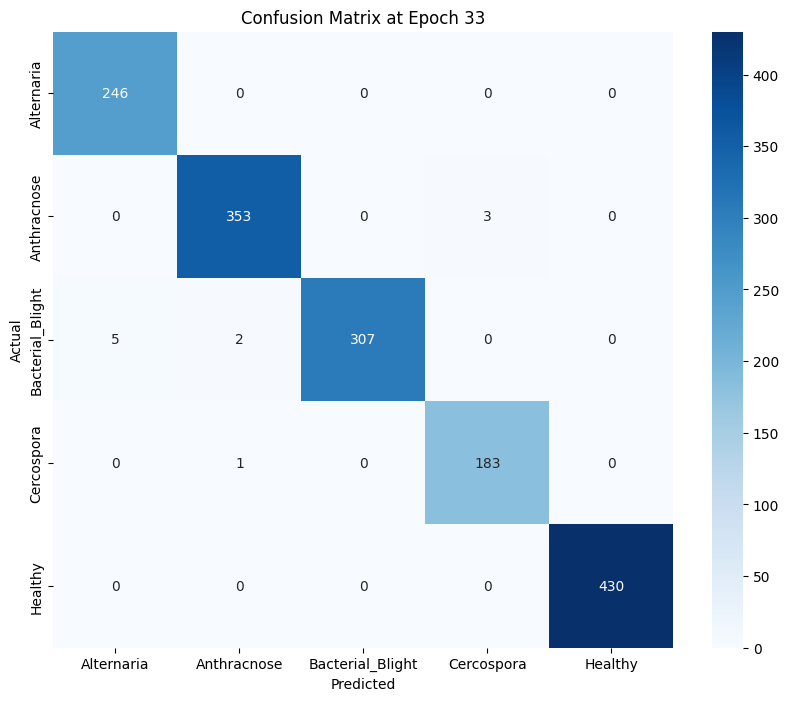

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_34.pth
Epoch : 34 Train Loss : 0.000277 Train Acc : 1.000000
Epoch 34/40 - Valid Loss: 0.0360, Accuracy: 0.9922, Precision: 0.9923, Recall: 0.9922, F1 Score: 0.9922


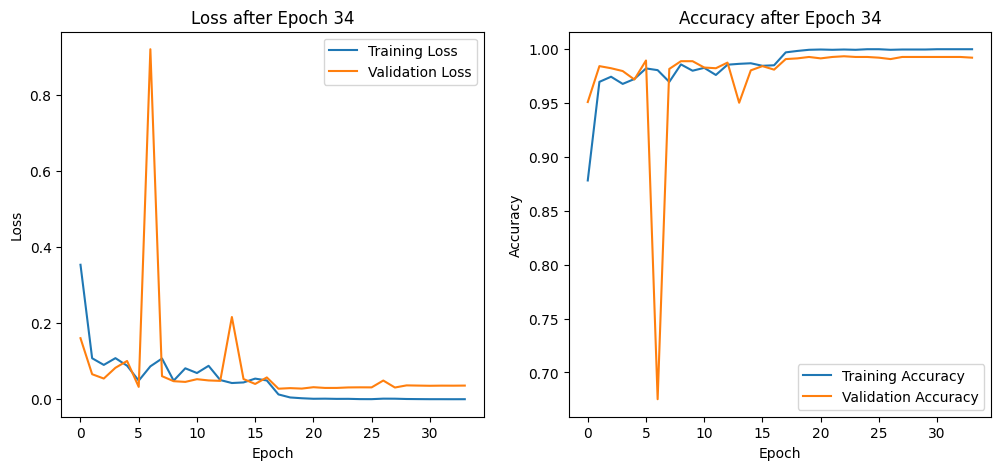

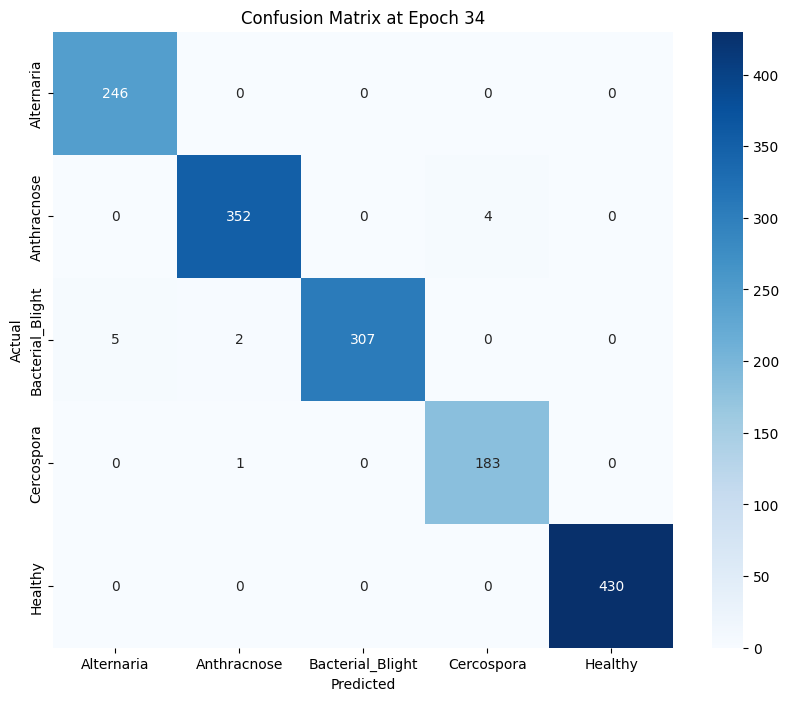

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_35.pth
Epoch : 35 Train Loss : 0.000205 Train Acc : 1.000000
Epoch 35/40 - Valid Loss: 0.0357, Accuracy: 0.9922, Precision: 0.9923, Recall: 0.9922, F1 Score: 0.9922


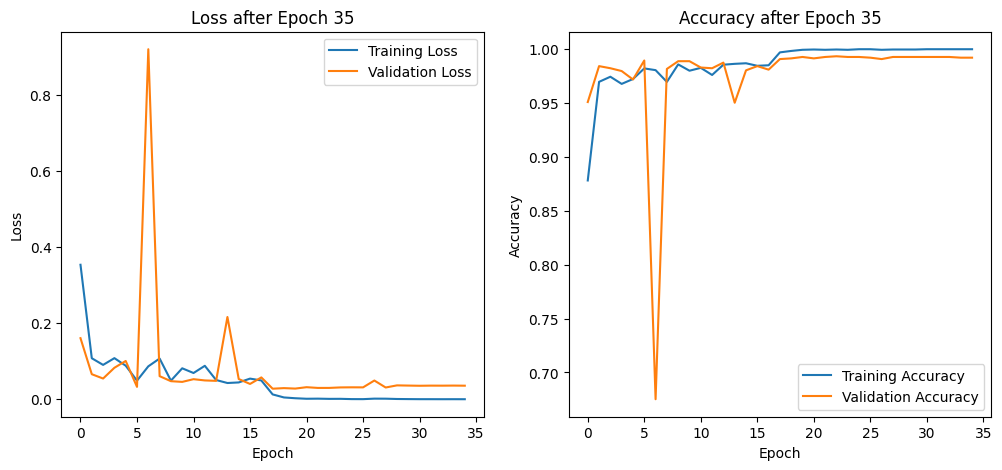

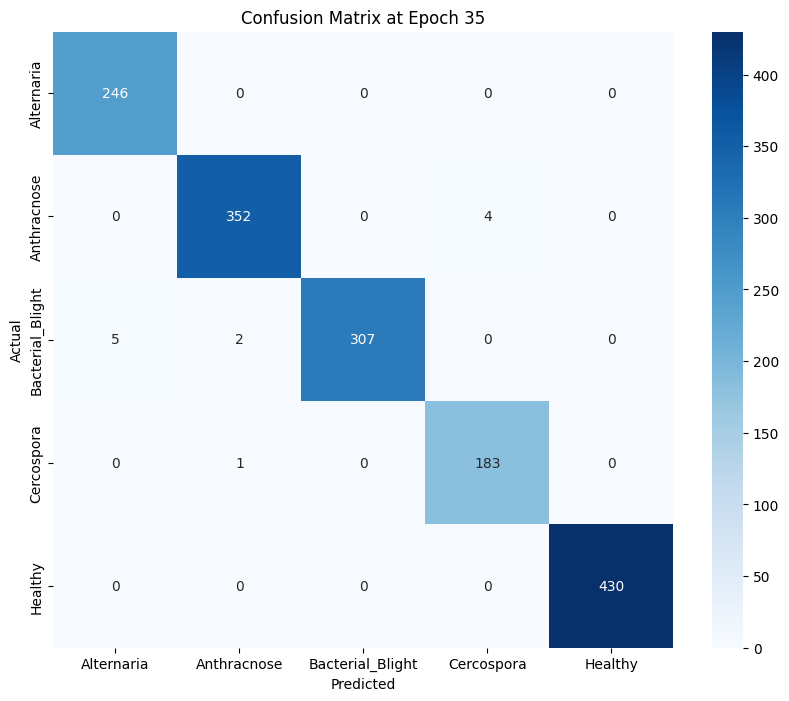

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_36.pth
Epoch : 36 Train Loss : 0.000240 Train Acc : 1.000000
Epoch 36/40 - Valid Loss: 0.0360, Accuracy: 0.9922, Precision: 0.9923, Recall: 0.9922, F1 Score: 0.9922


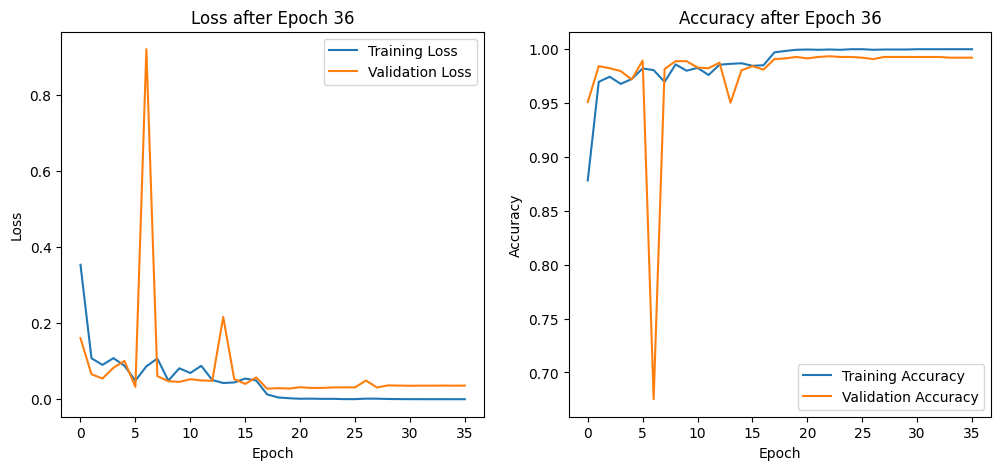

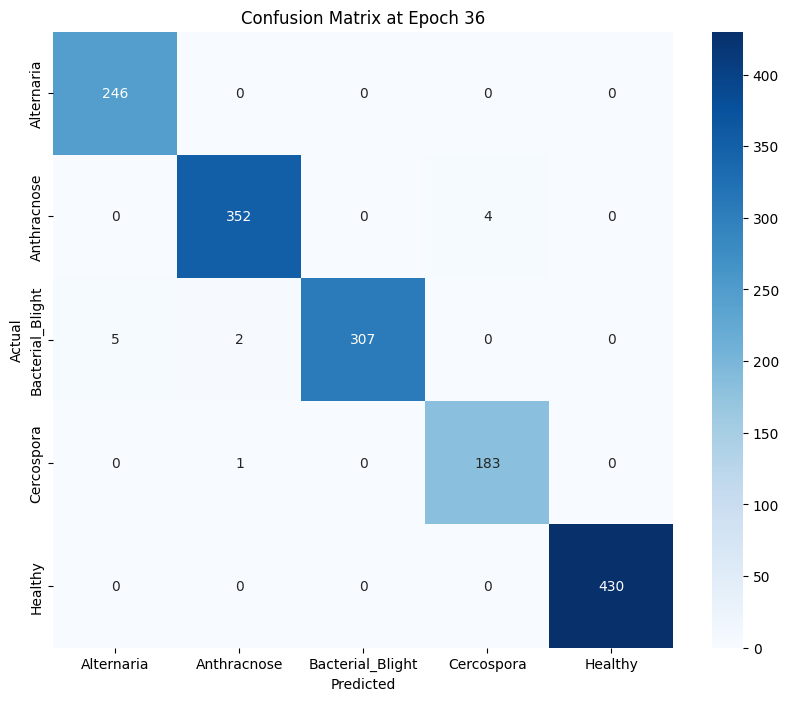

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_37.pth
Epoch : 37 Train Loss : 0.000231 Train Acc : 1.000000
Epoch 37/40 - Valid Loss: 0.0356, Accuracy: 0.9922, Precision: 0.9923, Recall: 0.9922, F1 Score: 0.9922


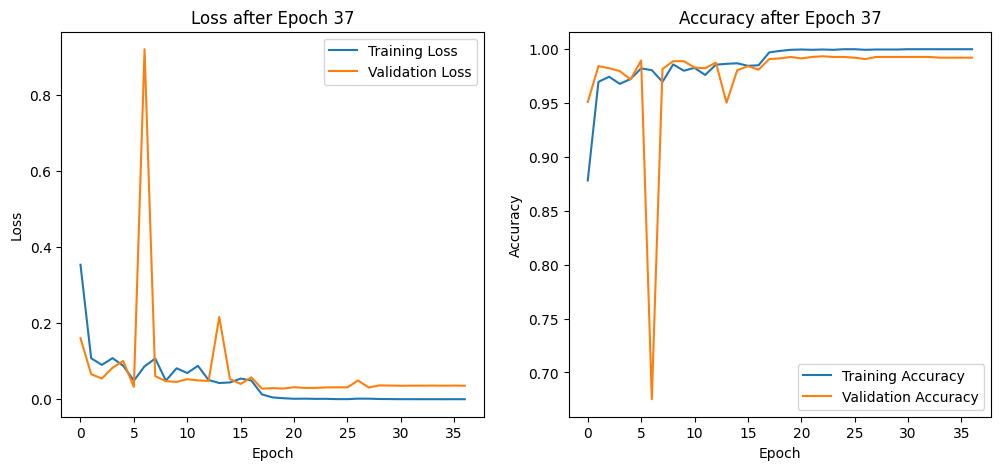

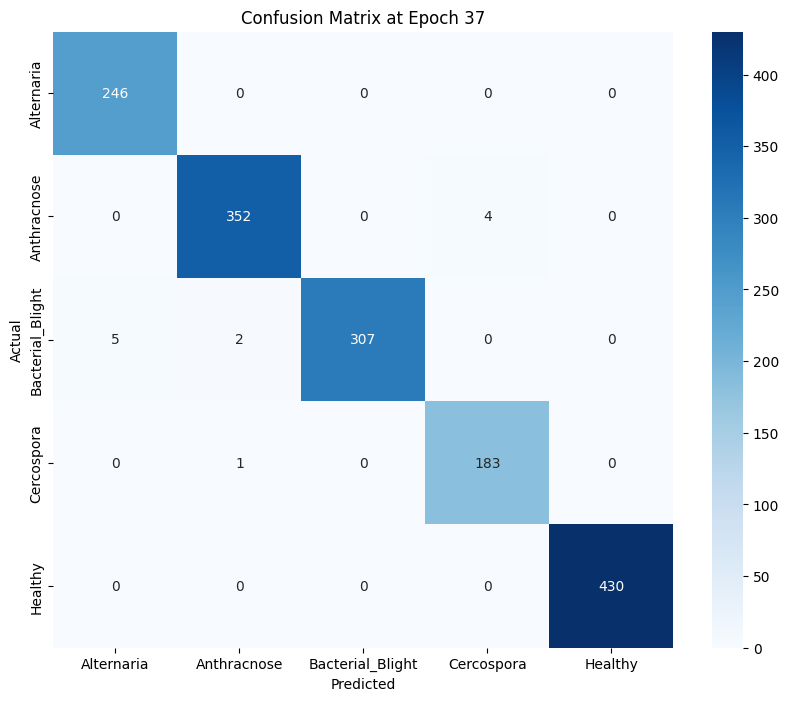

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_38.pth
Epoch : 38 Train Loss : 0.000306 Train Acc : 1.000000
Epoch 38/40 - Valid Loss: 0.0351, Accuracy: 0.9922, Precision: 0.9923, Recall: 0.9922, F1 Score: 0.9922


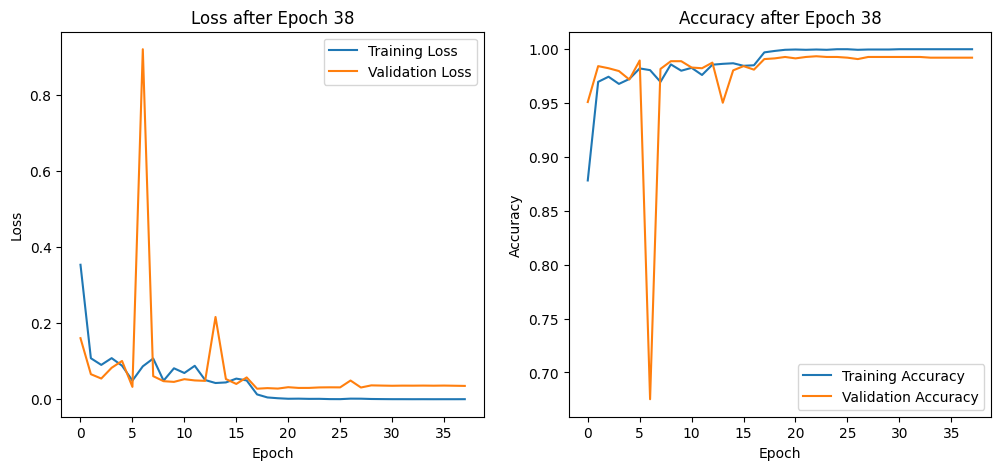

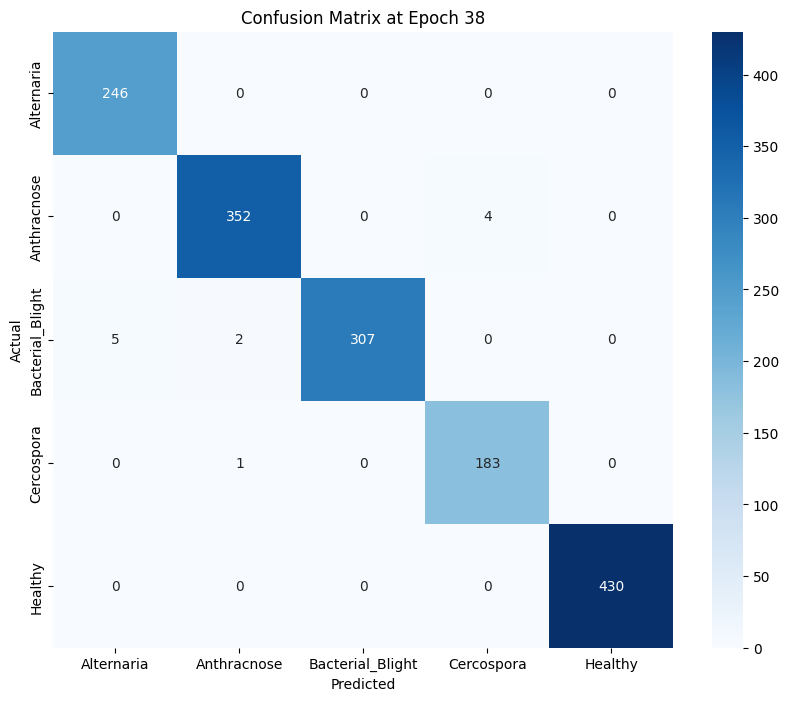

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_39.pth
Epoch : 39 Train Loss : 0.000190 Train Acc : 1.000000
Epoch 39/40 - Valid Loss: 0.0352, Accuracy: 0.9928, Precision: 0.9929, Recall: 0.9928, F1 Score: 0.9928


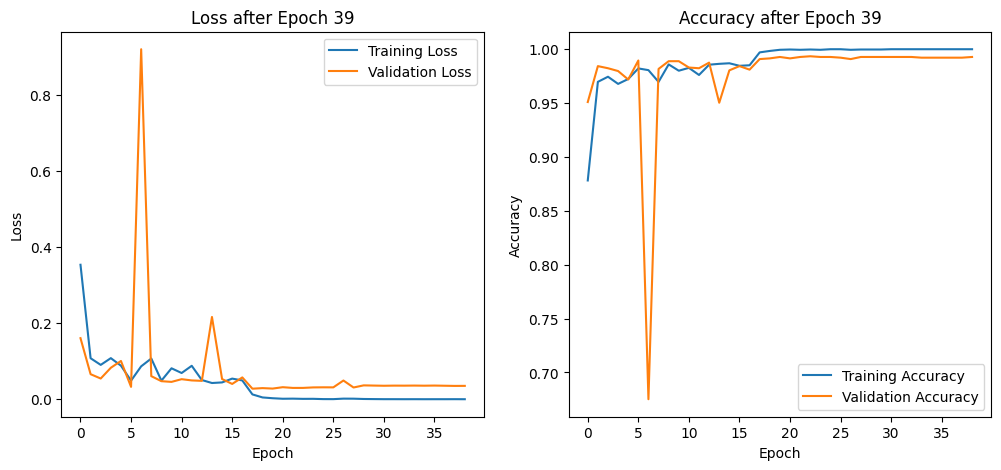

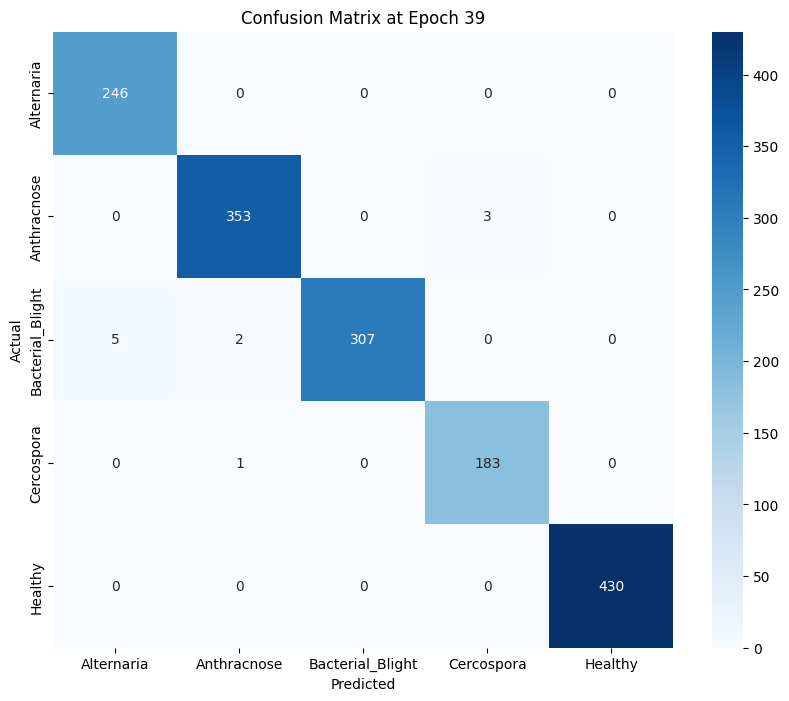

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Model saved as DaViT_Base_Epoch_40.pth
Epoch : 40 Train Loss : 0.000271 Train Acc : 1.000000
Epoch 40/40 - Valid Loss: 0.0350, Accuracy: 0.9922, Precision: 0.9922, Recall: 0.9922, F1 Score: 0.9922


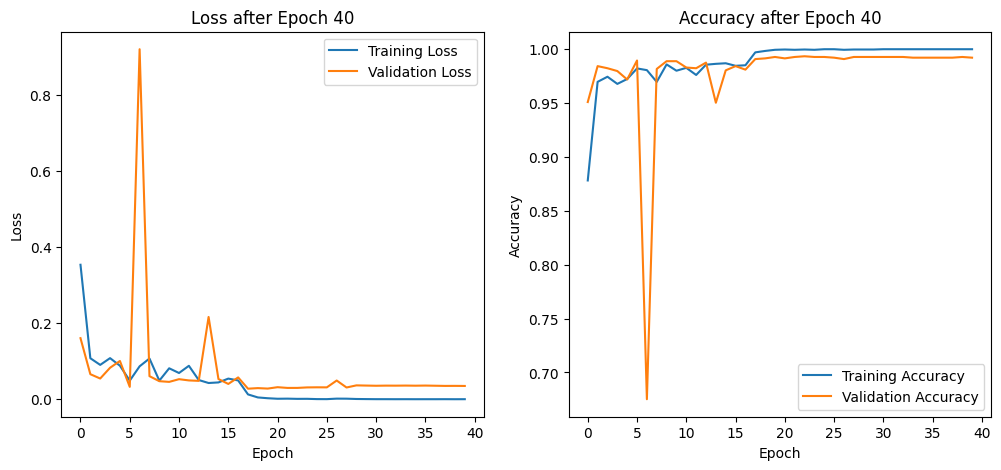

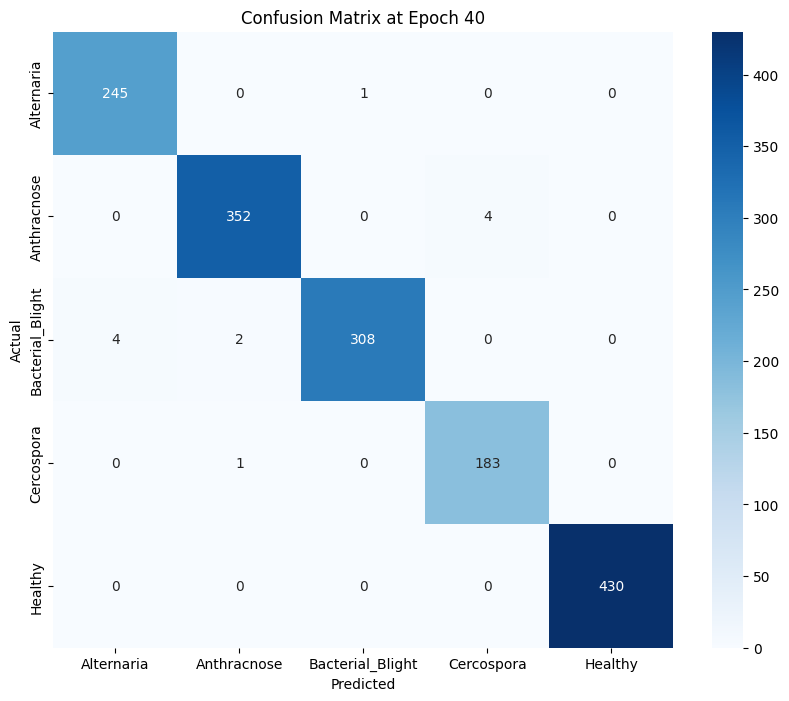

In [21]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Using Cross-Entropy Loss as the criterion for the classification task
criterion = nn.CrossEntropyLoss()

# Setting up the optimizer - Adam optimizer with a learning rate from CFG
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

schedular = ReduceLROnPlateau(optimizer, 'min')  # 'min' for minimizing the validation loss

# Instantiating the PneumoniaTrainer class with the defined criterion and optimizer
trainer = Trainer(criterion, optimizer, schedular)

# Using the fit method of PneumoniaTrainer to start the training and validation process
trainer.fit(model, train_loader, val_loader, epochs=40, device=device)

In [ ]:
del model  # Delete the model
torch.cuda.empty_cache()  # Clear GPU cache
print(torch.cuda.memory_allocated()/1024**2)
print(torch.cuda.memory_reserved()/1024**2)

In [24]:
conf_matrix = [
    [245, 0, 1, 0, 0],
    [0, 352, 0, 4, 0],
    [4, 2, 308, 0, 0],
    [0, 1, 0, 183, 0],
    [0, 0, 0, 0, 430],
]

In [31]:
weighted_conf_matrix = np.zeros_like(conf_matrix)
for i, row in enumerate(conf_matrix):
    weighted_conf_matrix[i, :] = [count * weights[i] for count in row]

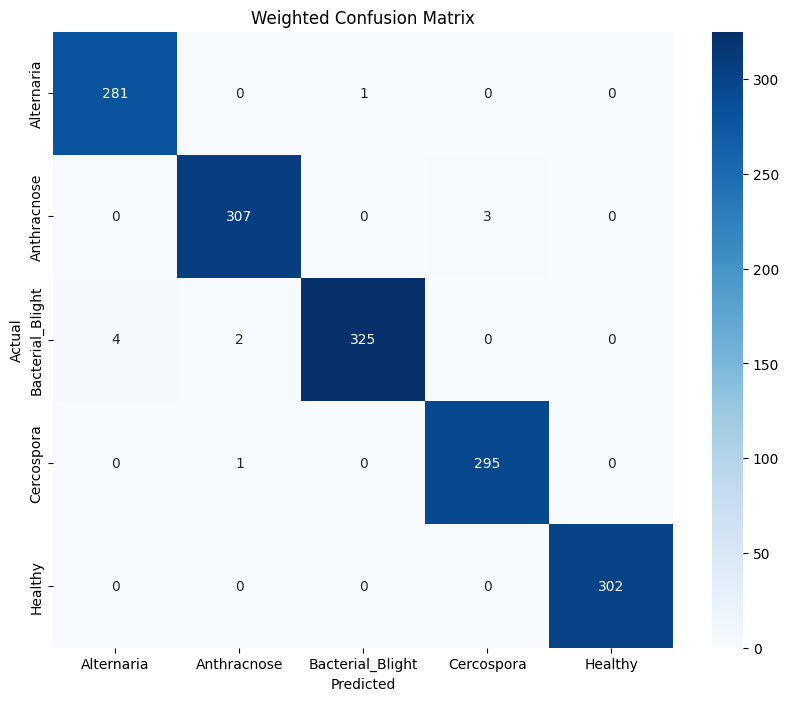

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(weighted_conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Weighted Confusion Matrix")
plt.show()